# Transfer Learning

In this notebook, we will classify T-cell activity by using off-the-shelf features extracted from a pre-trained deep CNN model Inception v3, or by retraining sub-layers of the pre-trained CNN. This transfer learning model will learn a non-linear relationship between image features and the output. Also, it is more efficient than training a deep CNN from scratch.

Inception v3 comprises multiple Inception modules, where each module can be considered as a concatenated neural network layer. In addition to comparing fine-tuning to directly using off-the-shelf features, we are interested in exploring if fine-tuning more Inception modules can help performance, so we denote the number of last Inception modules to fine-tune as `n` and treat it as a hyper-parameter along with `learning rate` and `batch size`. Then, we can use nested cross-validation to tune these values and test the final models. You can learn more about the nested cross-validation scheme in [logistic_regression.ipynb](logistic_regression.ipynb#1.-Nested-Cross-Validation-Scheme). We will use `Keras` with `Tensorflow` backend to implement the neural network.

## Table of Contents

<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Data-Preparation" data-toc-modified-id="1.-Data-Preparation-1">1. Data Preparation</a></span><ul class="toc-item"><li><span><a href="#1.1.-Extract-Bottlenecks" data-toc-modified-id="1.1.-Extract-Bottlenecks-1.1">1.1. Extract Bottlenecks</a></span></li><li><span><a href="#1.2.-Extract-Image-Features" data-toc-modified-id="1.2.-Extract-Image-Features-1.2">1.2. Extract Image Features</a></span></li><li><span><a href="#1.3.-Data-Generator-Pipeline" data-toc-modified-id="1.3.-Data-Generator-Pipeline-1.3">1.3. Data Generator Pipeline</a></span><ul class="toc-item"><li><span><a href="#1.3.1-Data-Generator:-Inner-Loop" data-toc-modified-id="1.3.1-Data-Generator:-Inner-Loop-1.3.1">1.3.1. Data Generator: Inner Loop</a></span></li><li><span><a href="#1.3.1-Data-Generator:-Outer-Loop" data-toc-modified-id="1.3.1-Data-Generator:-Outer-Loop-1.3.2">1.3.2. Data Generator: Outer Loop</a></span></li></ul></li></ul></li><li><span><a href="#2.-Model-Tuning/Training" data-toc-modified-id="2.-Model-Tuning/Training-2">2. Model Tuning/Training</a></span><ul class="toc-item"><li><span><a href="#2.1.-Building-Network:-Off-the-shelf-Model" data-toc-modified-id="2.1.-Building-Network:-Off-the-shelf-Model-2.1">2.1. Building Network: Off-the-shelf Model</a></span></li><li><span><a href="#2.2.-Building-Network:-Fine-tuning-Model" data-toc-modified-id="2.2.-Building-Network:-Fine-tuning-Model-2.2">2.2. Building Network: Fine-tuning Model</a></span></li><li><span><a href="#2.3.-Auto-checkpoint-Retraining-Process" data-toc-modified-id="2.3.-Auto-checkpoint-Retraining-Process-2.3">2.3. Auto-checkpoint Retraining Process</a></span></li><li><span><a href="#2.4.-Nested-Cross-validation" data-toc-modified-id="2.4.-Nested-Cross-validation-2.4">2.4. Nested Cross-validation</a></span></li><li><span><a href="#2.5.-Aggregate-Cross-validation-Results" data-toc-modified-id="2.5.-Aggregate-Cross-validation-Results-2.5">2.5. Aggregate Cross-validation Results</a></span><ul class="toc-item"><li><span><a href="#2.5.1.-Tuning-Results:-Off-the-shelf-Model" data-toc-modified-id="2.5.1.-Tuning-Results:-Off-the-shelf-Model-2.5.1">2.5.1. Tuning Results: Off-the-shelf Model</a></span></li><li><span><a href="#2.5.2.-Tuning-Results:-Fine-tuning-Model" data-toc-modified-id="2.5.2.-Tuning-Results:-Fine-tuning-Model-2.5.2">2.5.2. Tuning Results: Fine-tuning Model</a></span></li></ul></li></ul></li><li><span><a href="#3.-Model-Testing" data-toc-modified-id="3.-Model-Testing-3">3. Model Testing</a></span><ul class="toc-item"><li><span><a href="#3.1.-Test-Results:-Off-the-shelf-Model" data-toc-modified-id="3.1.-Test-Results:-Off-the-shelf-Model-3.1">3.1. Test Results: Off-the-shelf Model</a></span></li><li><span><a href="#3.2.-Test-Results:-Fine-tuning-Model" data-toc-modified-id="3.2.-Test-Results:-Fine-tuning-Model-3.2">3.2. Test Results: Fine-tuning Model</a></span></li></ul></li><li><span><a href="#4.-Model-Interpretation" data-toc-modified-id="4.-Model-Interpretation-4">4. Model Interpretation</a></span><ul class="toc-item"><li><span><a href="#4.1.-Last-Layer-Feature-Clustering" data-toc-modified-id="4.1.-Last-Layer-Feature-Clustering-4.1">4.1. Last Layer Feature Clustering</a></span></li><li><span><a href="#4.2.-Temperature-Scaling" data-toc-modified-id="4.2.-Temperature-Scaling-4.2">4.2. Temperature Scaling</a></span></li><li><span><a href="#4.3.-Misclassified-Image-Visualization" data-toc-modified-id="4.3.-Misclassified-Image-Visualization-4.3">4.3. Misclassified Image Visualization</a></span></li><li><span><a href="#4.4.-Saliency-Map" data-toc-modified-id="4.4.-Saliency-Map-4.4">4.4. Saliency Map</a></span></li></ul></li><li><span><a href="#5.-Model-Comparison" data-toc-modified-id="5.-Model-Comparison-5">5. Model Comparison</a></span></li><li><span><a href="#6.-Final-Evaluation-on-Held-out-Donor-4" data-toc-modified-id="6.-Final-Evaluation-on-Held-out-Donor-4-6">6. Final Evaluation on Held-out Donor 4</a></span><ul class="toc-item"><li><span><a href="#6.1.-Extract-Bottlenecks" data-toc-modified-id="6.1.-Extract-Bottlenecks-6.1">6.1. Extract Bottlenecks</a></span></li><li><span><a href="#6.2.-Model-Tuning" data-toc-modified-id="6.2.-Model-Tuning-6.2">6.2. Model Tuning</a></span></li><li><span><a href="#6.3.-Model-Testing" data-toc-modified-id="6.3.-Model-Testing-6.3">6.3. Model Testing</a></span></li></ul></li><li><span><a href="#7.-Summary" data-toc-modified-id="7.-Summary-7">7. Summary</a></span></li></ul></div>

## 1. Data Preparation

In [1]:
import numpy as np
import cv2
import re
import pandas as pd
import os
import platform
import urllib.request
import hashlib
import zipfile
import math
import umap
import tensorflow as tf
from numpy.random import seed
from glob import glob
from os.path import basename, join, exists
from collections import Counter
from matplotlib import pyplot as plt
from keras.models import Model
from keras.utils import Sequence
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers, layers, activations
from keras import backend as K
from keras.layers import Dense, GlobalAveragePooling2D, Input, MaxPooling2D, \
    Activation, BatchNormalization, Conv2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from tensorflow import set_random_seed
from vis.utils import utils
from vis.visualization import visualize_saliency
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.utils.extmath import softmax
from json import dump, load
from IPython.display import display, Markdown

# Call ggplot2 code from this notebook
%load_ext rpy2.ipython

# We set a random seed to make the notebook results consistent
RANDOM_SEED = 53715
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)
# Keras does not have good multithreading support for Windows
# If the current OS is Windows, we do not use multiprocessing
CUR_OS = platform.system()

Using TensorFlow backend.


Before running any cells in this notebook, you want to first download and unzip `bottlenecks.zip` and `saved_weights_donor_1.zip` from [Zenodo](https://doi.org/10.5281/zenodo.2640835). These files include extracted image features (discussed in [1.1 Extract Bottlenecks](#1.1.-Extract-Bottlenecks)), and training weights for the test model for donor 1 (discussed in [3. Model Test](#3.-Model-Testing) and [4. Model Interpretation](#4.-Model-Interpretation)).

The code below checks if you already have these resources. If not, it downloads and unzips them for you.

In [2]:
if not exists('./resource/saved_weights_fine_tuning_donor_1.h5'):
    # Download the weight file, retry 10 times
    for i in range(10):
        print("Downloading saved_weights_donor_1.zip - try {}".format(i + 1))
        try:
            urllib.request.urlretrieve(
                'https://zenodo.org/record/3259371/files/saved_weights_donor_1.zip',
                './saved_weights_donor_1.zip'
            )
            
            # Check md5sum
            md5sum = hashlib.md5(
                open('./saved_weights_donor_1.zip','rb').read()
            ).hexdigest()
            if md5sum != 'e6d2f53f652ef7084fa2e8640ff1dc07':
                continue
            
            # Unzip this file
            zip_ref = zipfile.ZipFile('./saved_weights_donor_1.zip', 'r')
            zip_ref.extractall(path='./resource')
            zip_ref.close()
            os.remove('./saved_weights_donor_1.zip')
            
            if exists('./resource/saved_weights_fine_tuning_donor_1.h5'):
                print("Successfully downloaded and unzipped weights.")
                break
            
        except:
            print("Encuntered error while downloading weights")
            continue

# Raise an exception if we can't download the weights after 10 times
if not exists('./resource/saved_weights_fine_tuning_donor_1.h5'):
    raise FileExistsError("Can't download weights")

In [3]:
def exist_bottlenecks():
    """
    Extensively check if all bottlenecks are in the right location.
    
    Return:
        True if user has all the bottlenecks. False for any bottleneck does
        not exist.
    """
    
    # Check if sub-dirs exist
    dir_temp = './images/sample_images/bottlenecks/bottleneck_mixed{}'
    have_dir = all([exists(dir_temp.format(layer)) for layer in [8, 9, 10]])
    
    # Check bottleneck counts
    have_correct_count = all(
        [len(glob(join(dir_temp.format(layer), '*.npz'))) == 5058 for
             layer in [8, 9, 10]]
    )

    return have_dir and have_correct_count


In [4]:
if not exist_bottlenecks():
    # Download the bottleneck zip file, retry 10 times
    for i in range(10):
        print("Downloading bottlenecks.zip - try {}".format(i + 1))
        try:
            urllib.request.urlretrieve(
                'https://zenodo.org/record/3259371/files/bottlenecks.zip',
                './bottlenecks.zip'
            )
            
            # Check md5sum
            md5sum = hashlib.md5(
                open('./bottlenecks.zip','rb').read()
            ).hexdigest()
            if md5sum != 'e4c93f7fcabe647fc58ab826e1dabbf9':
                continue
            
            # Unzip this file
            zip_ref = zipfile.ZipFile('./bottlenecks.zip', 'r')
            zip_ref.extractall(path='./images/sample_images')
            zip_ref.close()
            os.remove('./bottlenecks.zip')
            
            if exist_bottlenecks():
                print("Successfully downloaded bottlenecks.")
                break
            
        except:
            print("Encuntered error while downloading bottlenecks")
            continue

# Raise an exception if we can't download the bottlenecks after 10 times
if not exist_bottlenecks:
    raise FileExistsError("Can't download bottlenecks")

### 1.1. Extract Bottlenecks

We consider two models for this transfer learning two approach. One version treats the pre-trained CNN as a feature extractor, and then trains a one-layer fully connected neural network from scratch with the extracted features. We call these features "off-the-shelf features," and this model as the "pre-trained CNN off-the-shelf model." The other model freezes some earlier layers and retrains, or "fine-tunes," other higher-level layers of the pre-trained CNN. We refer to this model as the "pre-trained CNN with fine-tuning."

For the pre-trained CNN with fine-tuning, because we are only retraining the last `n` layers, it is more efficient to extract image features from earlier layers instead of feeding image pixels into the whole CNN model. Therefore, we can think of the last `n` layers as an "independent" CNN network initialized with pre-trained weights, and we fine-tune it using these extracted features as input.

These features extracted from the earlier layers are sometimes called an "image feature vector" or "bottleneck". With different `n`, the bottlenecks are different. Since we treat `n` as a hyper-parameter, we want to generate all versions of bottlenecks corresponding to every value of `n` (from $1$ to $11$). In our study, we are fine-tuning this CNN model end-to-end when `n=11`. In this case, we can directly use image pixel features. The data preparation for `n=11` is discussed in [1.2. Extract Image Features](#1.2.-Extract-Image-Features). Also, off-the-shelf features can be viewed as special bottlenecks with `n=0`.

Working with deep CNN is computationally expensive, even for our small subset of sample images. Therefore, we only consider the off-the-shelf model (`n=0`) as well as the fine-tuning model with `n=1` and `n=2` in this notebook. The code works for other `n` values.

<img src="plots/bottleneck.png" />

In [5]:
def generate_bottleneck(data_dir, output_dir, image_size, mapping,
                        bottleneck_model, image_format='png'):
    """
    Generate bottlenecks for all images in data_dir, then saves the bottleneck
    features for each image as a npz file in output_dir.

    Args:
        data_dir(string): path to the data directory. This directory is
            expected to have n_class subdirectories, where each contains data
            of one class.
        output_dir(string): the directory to store extracted bottlenecks
        image_size(tuple): expected image shape
        mapping(dict): a dictionary mapping labels to integers
            {
            'label_1': 0,
            'label_2': 1
            }
        bottleneck_model(keras.model): the bottleneck model to extract features
        image_format(string): the image format, default is png
    """
    
    # Load the image name and their labels
    for label in mapping:
        sub_dir = join(data_dir, label)

        if not exists(sub_dir):
            print("can't find {} directory".format(label))
            continue

        for image_name in glob(join(sub_dir, "*.{}".format(image_format))):
            # Load and resize image
            image_data = np.array([resize(imread(image_name, as_gray=True),
                                          image_size, mode='constant',
                                          anti_aliasing=None)])

            # Extract features from the image (generate bottleneck)
            # We use [0] because it returns a batch of predictions
            bottleneck_features = bottleneck_model.predict(image_data)[0]

            # Store the bottleneck as a compresed npz file. It shares the same
            # naming scheme as the input image.
            npz_path = join(output_dir, basename(image_name).replace('png',
                                                                     'npz'))
            np.savez_compressed(npz_path, features=bottleneck_features)

Then, we can define a wrapper function to generate bottlenecks for each $n$ value. In the pre-trained Inception V3 model with ImageNet weights in Keras uses `mixed*` to denote the concatenated layer of Inception modules. For example, `mixed10` is the concatenated layer of the 11th Inception modules (the last one). We will use this to select the range of retraining layers in this notebook.

In [6]:
def make_bottleneck_main(pre_layer, donors=[1, 2, 3, 4, 5, 6]):
    """
    The main function to pre-generate bottlenecks for different starting layers.
    
    Args:
        pre_layer(string): The name of the layer before the starting layer.
            For example, if you want to retrain 'mixed10', then pre_layer is
            'mixed9'. If you want to implement the off-the-shelf model, then
            pre_layer is 'mixed10'.
        donors([int]): A list of donors from which you want to extract bottlenecks.
    """
    
    # Compile a bottleneck model based on the given pre_layer
    base_model = InceptionV3(weights='imagenet', include_top=True)
    bottleneck_model = Model(
        inputs=base_model.input,
        outputs=base_model.get_layer(pre_layer).output
    )

    # The pre-trained Inception model expects (299, 299, 3) input
    image_size = (299, 299, 3)
    data_dir = './images/sample_images/processed/augmented/donor_{}/'
    output_dir = './images/sample_images/bottlenecks/bottleneck_{}'.format(
        pre_layer
    )
    mapping = {'activated': 1, 'quiescent': 0}
    
    # Create output directory
    if not exists(output_dir):
        os.makedirs(output_dir)

    # Save one bottleneck for each donor per layer
    for donor in donors:
        print('Start generating {} bottlenecks for donor {}.'.format(pre_layer,
                                                                    donor))
        generate_bottleneck(data_dir.format(donor), output_dir, image_size,
                            mapping, bottleneck_model)

In [7]:
# This code takes about 30 minutes
# make_bottleneck_main('mixed10')

In [8]:
# This code takes about 30 minutes
# make_bottleneck_main('mixed9')

In [9]:
# This code takes about 30 minutes
# make_bottleneck_main('mixed8')

### 1.2. Extract Image Features



For the special case `n=11`, we are fine-tuning the whole Inception v3 model end-to-end, so there is no need to extract bottlenecks. Instead, we directly resize the images and use their pixel features.

In [10]:
def make_train_data_main(donors=[1, 2, 3, 4, 5, 6]):
    """
    The main function to generate images with right size for training a complete
    new Inception v3 model.
    
    Args:
        donors([int]): A list of donors that you want to extract image features.
    """
    
    # The pre-trained Inception model expects (299, 299, 3) input
    image_size = (299, 299, 3)
    data_dir = './images/sample_images/processed/augmented/donor_{}/'
    mapping = {'activated': 1, 'quiescent': 0}
    
    # By our convention to name the "bottleneck", the pre_layer here is -1
    pre_layer = 'mixed-1'
    output_dir = './images/sample_images/bottlenecks/bottleneck_{}'.format(
        pre_layer
    )
    
    # Create output directory
    if not exists(output_dir):
        os.makedirs(output_dir)

    for donor in donors:
        print('Start generating {} bottlenecks for donor {}.'.format(pre_layer,
                                                                    donor))
        
        features, labels, names = [], [], []

        # Load the image name and their labels
        for label in mapping:
            sub_dir = join(data_dir, label).format(donor)

            if not exists(sub_dir):
                print("can't find {} directory for donor {}".format(label,
                                                                    donor))
                continue

            for image_name in glob(join(sub_dir, "*.{}".format('png'))):
                # Load and resize image
                image_data = resize(imread(image_name, as_gray=True),
                                    image_size, mode='constant',
                                    anti_aliasing=None)
                
                # Store the bottleneck as a compressed npz file. It shares the same
                # naming scheme as the input image.
                npz_path = join(output_dir, basename(image_name).replace('png',
                                                                     'npz'))
                np.savez_compressed(npz_path, features=image_data)

Since we don't include `n=11` (`mixed-1`) in this notebook, we won't run the code below.

In [11]:
# make_train_data_main()

### 1.3. Data Generator Pipeline

Similar to the infrastructure of the simple neural network and simple CNN, we want to develop a pipeline to generate training data on multiple cores in real time and feed them to the model, because the memory cannot hold all training data at once. To implement this, we can make an instance of `keras.utils.Sequence` and customize the data generation rule.

In [12]:
class DataGenerator(Sequence):
    """
    Implement the DataGenerator class (instance of Sequence), so we can feed the
    training model with better parallel computing support.
    
    In this inherited class, we want to implement __getitem__ and the __len__
    methods.
    """
        
    def __init__(self, filenames, y, batch_size=32):
        """
        Args:
            filenames([string]): filenames of npz files that store training
                features
            y([int]): labels corresponding to the filenames list
            batch_size(int): number of training samples per epoch
        """
        self.filenames, self.y = shuffle(filenames, y)

        self.batch_size = batch_size
        self.indexes = np.arange(len(filenames))

    def __len__(self):
        """
        This method tells keras how many times to go through the whole sample.
        """
        
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, index):
        """
        This method generates one batch of data.
        
        Args:
            index(int): Current batch index
        """
        
        # Get the current batch info
        batch_indexes = self.indexes[index * self.batch_size:
                                     (index + 1) * self.batch_size]
        batch_filenames = np.array(self.filenames)[batch_indexes]
        batch_y = self.y[batch_indexes, :]
        
        # Fetch features in this batch from local npz files
        batch_x = []
        for f in batch_filenames:
            npz = np.load(f)
            batch_x.append(npz['features'])
        batch_x = np.stack(batch_x, axis=0)

        return batch_x, batch_y

Then, we want to write a function to partition bottlenecks into train, validation, and test sets according to the nested cross-validation scheme. The partition scheme is different for the inner loop and outer loop. We define `partition_data_cv()` and `partition_data_test()` for the inner loop and outer loop, respectively.

<img src="./plots/cross_validation.png" width="600">

In the figure above, we refer to the inner loop test set as the "Validation" set, because it is used to validate hyper-parameters. However, to avoid confusion, we call it the test set in the implementation below. The detailed set descriptions are listed below.


<table width="600">
  <thead>
    <th style="text-align: left;">Stage</th>
    <th style="text-align: left;">Set Name</th>
    <th style="text-align: left;">Composition</th>
    <th style="text-align: left;">Use</th>
  </thead>
  <tr>
    <td style="text-align: left;">Inner loop</td>
    <td style="text-align: left;">Train set</td>
    <td style="text-align: left;">Three-fourths of augmented images from donors that are not the validation donor nor the test donor</td>
    <td style="text-align: left;">Train a model with a combination of hyper-parameters</td>
  </tr>
  <tr>
    <td style="text-align: left;">Inner loop</td>
    <td style="text-align: left;">Validation set</td>
    <td style="text-align: left;">One-fourths of unaugmented images from donors that are not the validation donor nor the test donor. <br><br> Their corresponding augmented images are not in the inner loop train set.</td>
    <td style="text-align: left;">Early stopping</td>
  </tr>
  <tr>
    <td style="text-align: left;">Inner loop</td>
    <td style="text-align: left;">Test set</td>
    <td style="text-align: left;">All unaugmented images from the validation donor</td>
    <td style="text-align: left;">Evaluate the inner loop model</td>
  </tr>
  <tr>
    <td style="text-align: left;">Outer loop</td>
    <td style="text-align: left;">Train set</td>
    <td style="text-align: left;">Three-fourths of augmented images from donors that are the test donor</td>
    <td style="text-align: left;">Train a model with a combination of hyper-parameters</td>
  </tr>
  <tr>
    <td style="text-align: left;">Outer loop</td>
    <td style="text-align: left;">Validation set</td>
    <td style="text-align: left;">One-fourths of unaugmented images from donors that are not the test donor. <br><br> Their corresponding augmented images are not in the outer loop train set.</td>
    <td style="text-align: left;">Early stopping</td>
  </tr>
  <tr>
    <td style="text-align: left;">Outer loop</td>
    <td style="text-align: left;">Test set</td>
    <td style="text-align: left;">All unaugmented images from the test donor</td>
    <td style="text-align: left;">Evaluate the outer loop model</td>
  </tr>
</table>

#### 1.3.1. Data Generator: Inner Loop

Function `partition_data_cv()` partitions bottlenecks into train, validation, and test set for hyper-parameter evaluation.

In [13]:
def partition_data_cv(bottleneck_dir, batch_size, test_did, vali_did,
                      donors=[1, 2, 3, 5, 6]):
    """
    Make train and vali generator for training and inner performance testing.
    
    Args:
        bottleneck_dir(string): directory containing all bottlenecks
        batch_size(int): batch size for training
        test_did(int): donor id for test set
        vali_did(int): donor id for validation set
        donors([int]): A list of donors that you want to sample images from,
            test_did and vali_did should be included in this list. You can use
            this argument to hold out some specific donors.

    Returns:
        train_data_generator(DataGenerator): DataGenerator for training data
        vali_data_generator(DataGenerator): DataGenerator for validation data
        test_data_generator(DataGenerator): DataGenerator for test data
        class_weight(dict): class weight based on label count in the traning data
    """

    print("\t=> Start splitting data...")

    # Only read donors that are on the `donors` list
    all_files = [basename(f) for f in glob(join(bottleneck_dir, '*.npz'))]
    all_files = [f for f in all_files if re.match(
        r'CD[38]_[{}]_.*'.format(''.join(map(str, donors))), f)]

    # Exclude vali did and test did from the filename list
    inner_all_files = [f for f in all_files if re.match(
        r'CD[38]_[^{}{}]_.*'.format(test_did, vali_did), f)]

    # Then, we want to split training and validation sets (3:1) within the
    # inner loop files. We split the data using their original image names, so
    # the validation set won't have augmented images left in the train set.

    # Get the original images (without augmentation)
    inner_original_files = [f for f in inner_all_files if 'r' not in f and
                            'f' not in f]

    # Now we split the origin names by 3:1
    inner_original_files = shuffle(inner_original_files,
                                   random_state=RANDOM_SEED)
    inner_split_index = len(inner_original_files) // 4
    inner_original_train = set(inner_original_files[inner_split_index:])
    inner_original_vali = set(inner_original_files[:inner_split_index])
    
    # Add associated files to their sets. For training set, we add original
    # files and augmented files. For validation set, we only add original
    # files.
    inner_train_files, inner_train_labels = [], []
    inner_vali_files, inner_vali_labels = [], []

    for i in range(len(inner_all_files)):
        n = inner_all_files[i]
        n_label = 0 if 'noact' in n else 1

        if 'r' in n or 'f' in n:
            # Extract the original name form
            cur_origin_name = re.sub(r'(.+_\d_.+_\d+_\d+_\d+)_.+\.npz',
                                     r'\1.npz', n)

            # Only put augmented images to the training set if their originals
            # are there
            if cur_origin_name in inner_original_train:
                inner_train_files.append(join(bottleneck_dir, n))
                inner_train_labels.append(n_label)
            elif cur_origin_name not in inner_original_vali:
                error = "Bad augmented images: {}, {}"
                print(error.format(n, cur_origin_name))

        else:
            # For original images, we just put it into the right set
            if n in inner_original_train:
                inner_train_files.append(join(bottleneck_dir, n))
                inner_train_labels.append(n_label)
            elif n in inner_original_vali:
                inner_vali_files.append(join(bottleneck_dir, n))
                inner_vali_labels.append(n_label)
            else:
                error = "Bad original images: {}, {}"
                print(error.format(n, cur_origin_name))

    # Count training set labels for class weighting
    count = Counter(inner_train_labels)

    # One-hot encode the labels
    inner_train_y = np.vstack([[0, 1] if l else [1, 0] for l in
                               inner_train_labels])
    inner_vali_y = np.vstack([[0, 1] if l else [1, 0] for l in
                              inner_vali_labels])

    # Fill the inner test set for parameter evaluation. It does not include
    # augmented images.
    inner_test_files, inner_test_labels = [], []
    for f in glob(join(bottleneck_dir, '*.npz')):
        filename = basename(f)
        if re.match(r'CD[38]_{}_.*'.format(vali_did), filename):
            if 'r' not in filename and 'f' not in filename:
                inner_test_files.append(join(bottleneck_dir, filename))
                inner_test_labels.append([1, 0] if 'noact' in filename else
                                         [0, 1])

    inner_test_y = np.vstack(inner_test_labels)

    # Compute class weighting based on the training set labels
    if count[1] > count[0]:
        class_weight = {1: 1.0, 0: count[1] / count[0]}
    else:
        class_weight = {1: count[0] / count[1], 0: 1.0}

    print('\t\tinner train size: ', len(inner_train_files))
    print('\t\tinner vali size: ', len(inner_vali_files))
    print('\t\tinner test size: ', len(inner_test_files))

    return (DataGenerator(inner_train_files, inner_train_y, batch_size),
            DataGenerator(inner_vali_files, inner_vali_y, batch_size),
            DataGenerator(inner_test_files, inner_test_y, batch_size),
            class_weight)


In [14]:
# Verify the partition_data_cv() function
temp_bottleneck_dir = './images/sample_images/bottlenecks/bottleneck_mixed10'
(train_gen, vali_gen, test_gen,
 class_weights) = partition_data_cv(temp_bottleneck_dir, 16, 1, 2)

print('train_gen batches: {}, vali_gen batches: {}, test_gen batches {}'.format(
    len(train_gen), len(vali_gen), len(test_gen)))
print('class_weights: {}'.format(class_weights))

	=> Start splitting data...
		inner train size:  1656
		inner vali size:  91
		inner test size:  80
train_gen batches: 104, vali_gen batches: 6, test_gen batches 5
class_weights: {1: 1.358974358974359, 0: 1.0}


#### 1.3.2. Data Generator: Outer Loop

Function `partition_data_test()` partitions bottlenecks into train, validation, and test set for final model testing.

In [15]:
def partition_data_test(bottleneck_dir, batch_size, test_did,
                        donors=[1, 2, 3, 5, 6]):
    """
    Make train, vali, and test generator for training the final model for one
    test donor. This function is not for cross validation. This generates data
    for the outer loop after selecting the optimal hyper-parameters.

    The training set and the validation set both include original and augmented
    images. Augmented images are always assigned to the same set with their
    associated original image. The test set has no augmented images.

    Args:
        bottleneck_dir(string): directory containing all bottlenecks
        batch_size(int): batch size for training
        test_did(int): donor id for test set
        donors([int]): A list of donors that you want to sample images from,
            test_did should be included in this list. You can use this argument
            to hold out some specific donors.
        
    Returns:
        train_data_generator(DataGenerator): DataGenerator for training data
        vali_data_generator(DataGenerator): DataGenerator for validation data
        test_data_generator(DataGenerator): DataGenerator for test data
        class_weight(dict): class weight based on label count in the traning data
    """

    print("\t=> Start splitting data...")

    # Only read donors that are on the `donors` list
    all_files = [basename(f) for f in glob(join(bottleneck_dir, '*.npz'))]
    all_files = [f for f in all_files if re.match(
        r'CD[38]_[{}]_.*'.format(''.join(map(str, donors))), f)]

    # Exclude test did from the filename list
    outer_all_files = [f for f in all_files if re.match(
        r'CD[38]_[^{}]_.*'.format(test_did), f
    )]

    # Then, we want to split training and validation sets (3:1) within these
    # files.

    # Get the original images (without augmentation)
    outer_original_files = [f for f in outer_all_files if 'r' not in f and
                            'f' not in f]

    # Now we split the origin names by 3:1
    outer_original_files = shuffle(outer_original_files,
                                   random_state=RANDOM_SEED)
    outer_split_index = len(outer_original_files) // 4
    outer_original_train = set(outer_original_files[outer_split_index:])
    outer_original_vali = set(outer_original_files[:outer_split_index])

    # Add associated files to their sets. For training set, we add original
    # files and augmented files. For validation set, we only add original
    # files.
    outer_train_files, outer_train_labels = [], []
    outer_vali_files, outer_vali_labels = [], []

    for i in range(len(outer_all_files)):
        n = outer_all_files[i]
        n_label = 0 if 'noact' in n else 1

        if 'r' in n or 'f' in n:
            # Extract the original name form
            cur_origin_name = re.sub(r'(.+_\d_.+_\d+_\d+_\d+)_.+\.npz',
                                     r'\1.npz', n)

            # Only put augmented images to the training set if their originals
            # are there
            if cur_origin_name in outer_original_train:
                outer_train_files.append(join(bottleneck_dir, n))
                outer_train_labels.append(n_label)
            elif cur_origin_name not in outer_original_vali:
                error = "Bad augmented images: {}, {}"
                print(error.format(n, cur_origin_name))

        else:
            # For original images, we just put it into the right set
            if n in outer_original_train:
                outer_train_files.append(join(bottleneck_dir, n))
                outer_train_labels.append(n_label)
            elif n in outer_original_vali:
                outer_vali_files.append(join(bottleneck_dir, n))
                outer_vali_labels.append(n_label)
            else:
                error = "Bad original images: {}, {}"
                print(error.format(n, cur_origin_name))

    # Count training set labels for class weighting
    count = Counter(outer_train_labels)

    # One-hot encoding for the labels
    outer_train_y = np.vstack([[0, 1] if l else [1, 0] for l in
                               outer_train_labels])
    outer_vali_y = np.vstack([[0, 1] if l else [1, 0] for l in
                              outer_vali_labels])

    # Finally, construct the test set using original features from test_did
    outer_test_files, outer_test_labels = [], []
    for f in glob(join(bottleneck_dir, '*.npz')):
        filename = basename(f)
        if re.match(r'CD[38]_{}_.*'.format(test_did), filename):
            if 'r' not in filename and 'f' not in filename:
                outer_test_files.append(join(bottleneck_dir, filename))
                outer_test_labels.append([1, 0] if 'noact' in filename else
                                         [0, 1])

    outer_test_y = np.vstack(outer_test_labels)

    # Compute class weighting based on the training set labels
    if count[1] > count[0]:
        class_weight = {1: 1.0, 0: count[1] / count[0]}
    else:
        class_weight = {1: count[0] / count[1], 0: 1.0}

    print('\t\touter train size: ', len(outer_train_files))
    print('\t\touter vali size: ', len(outer_vali_files))
    print('\t\touter test size: ', len(outer_test_files))

    # No need to output additional validation/test dataset information for
    # computing temperature scaling or error image labels
    # Use datagenerator.filenames instead
    return (DataGenerator(outer_train_files, outer_train_y, batch_size),
            DataGenerator(outer_vali_files, outer_vali_y, batch_size),
            DataGenerator(outer_test_files, outer_test_y, batch_size),
            class_weight)


In [16]:
# Verify the partition_data_test() function
temp_bottleneck_dir = './images/sample_images/bottlenecks/bottleneck_mixed10'
(train_gen, vali_gen, test_gen,
 class_weights) = partition_data_test(temp_bottleneck_dir, 16, 1)

print('train_gen batches: {}, vali_gen batches: {}, test_gen batches {}'.format(
    len(train_gen), len(vali_gen), len(test_gen)))
print('class_weights: {}'.format(class_weights))

	=> Start splitting data...
		outer train size:  2016
		outer vali size:  111
		outer test size:  185
train_gen batches: 126, vali_gen batches: 7, test_gen batches 12
class_weights: {1: 1.048780487804878, 0: 1.0}


In [17]:
# Clean memory use of section 1
del (train_gen, vali_gen, test_gen, class_weights)

## 2. Model Tuning/Training

In this section, we want to implement the nested cross-validation tuning and training for pre-trained CNN off-the-shelf model and pre-trained CNN with fine-tuning. The hyper-parameters are `learning rate`, `batch size`, and `n`. `batch size` is configured in `partition_data_cv()` and `DataGenerator`.

### 2.1. Building Network: Off-the-shelf Model

The off-the-shelf model is simple: we are simply building a new one-layer fully-connected neural network on top of those extracted off-the-shelf features (bottlenecks with `n=0`).

In [18]:
def get_off_the_shelf_model():
    """
    Create a fully connected neural network that trains on
    off-the-shelf features. It adds a pooling layer after the mixed10
    output and a fully connected layer before the output layer.
    
    Return:
        model: a Keras neural network model
    """
    input_layer = Input(shape=(8, 8, 2048))

    # The input layer (mixed10) is a concatenated convolutional layer
    # Add a pooling layer after it
    x = GlobalAveragePooling2D()(input_layer)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=predictions)

    return model

In [19]:
off_the_shelf_model = get_off_the_shelf_model()
off_the_shelf_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8, 2048)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 2,100,226
Trainable params: 2,100,226
Non-trainable params: 0
_________________________________________________________________


### 2.2. Building Network: Fine-tuning Model

We want to build a network only comprising fine-tuning layers. As discussed in [1.1. Extract Bottlenecks](#1.1.-Extract-Bottlenecks), we split the complete Inception V3 model into two parts; we use the first part to extract bottlenecks, and we use bottlenecks to fine-tune the remaining layers. Here, we want to have a function to dynamically generate and initialize (with pre-trained weights) the second part by different `n` values.

It is not easy to split layers of the `InceptionV3` model from `keras.applications.inception_v3`. One alternative is to use the original model by setting non-retraining layers to `untrainable`, but this is not taking advantage of bottleneck cache. Therefore, we can refer to the `Keras` source code of `InceptionV3` to implement our own construction functions.

The following functions `conv2d_bn()` and `create_model_multiple_layers()` are referring to [`inception_v3.py`](https://github.com/keras-team/keras/blob/b0f1bb9c7c68e24137a9dc284dc210eb0050a6b4/keras/applications/inception_v3.py) written by the Keras team. The latest version of `inception_v3.py` is maintained at [here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/inception_v3.py). The original version has some misleading comments, but they are later fixed in the newer version. You can learn more on this [issue](https://github.com/keras-team/keras-applications/issues/39).

In [20]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1),
              name=None):
    """
    Utility function to apply conv + BN.
    
    Args:
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
            
    Returns:
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x

In [21]:
def transfer_weights(new_model, bottleneck_layer):
    """
    Initialize new_model weights using pre-trained ImageNet weights.

    Args:
        new_model: a Keras model which is a sub-network of Inception v3
        bottleneck_layer: name of the bottleneck layer, e.g. 'mixed9'.
            The input layer of `new_model` is the layer right after
            `bottleneck_layer` in the complete Inception v3.
    """
    
    imagenet_model = InceptionV3(include_top=True, weights='imagenet')

    # Find the starting point in the complete network
    # Special case for n = 11
    if bottleneck_layer == 'none':
        input_index = 0
    else:
        input_index = None
    for index, layer in enumerate(imagenet_model.layers):
        if layer.name == bottleneck_layer:
            input_index = index
            break

    # Transfer the weights from the complete network to our sub-network
    # No need to copy the weights of input and output layer
    for i in range(1, len(new_model.layers) - 1):
        new_model.layers[i].set_weights(
            imagenet_model.layers[input_index + i].get_weights()
        )

In [22]:
def create_model_multiple_layers(layer=1):
    """
    Fine-tune some of the last layers instead of adding a fully connected layer.

    Args:
        layer(int): 1 => Retrain mixed10
                    2 => Retrain mixed9, 10
                    3 => Retrain mixed8, 9 , 10
                    4 => Retrain mixed7, 8, 9, 10
                    5 => Retrain mixed6, 7, 8, 9, 10
                    6 => Retrain mixed5, 6, 7, 8, 9, 10
                    7 => Retrain mixed4, 5, 6, 7, 8, 9, 10
                    8 => Retrain mixed3, 4, 5, 6, 7, 8, 9, 10
                    9 => Retrain mixed2, 3, 4, 5, 6, 7, 8, 9, 10
                    10 => Retrain mixed1, 2, 3, 4, 5, 6, 7, 8, 9, 10
                    11 => Train the entire Inception v3 from scratch

    Return:
        train_model: the second part of Inception v3 that we want to retrain
            using extracted bottlenecks
    """
    
    # Constant config diction
    config = {
        1: ['mixed9', (8, 8, 2048)],
        2: ['mixed8', (8, 8, 1280)],
        3: ['mixed7', (17, 17, 768)],
        4: ['mixed6', (17, 17, 768)],
        5: ['mixed5', (17, 17, 768)],
        6: ['mixed4', (17, 17, 768)],
        7: ['mixed3', (17, 17, 768)],
        8: ['mixed2', (35, 35, 288)],
        9: ['mixed1', (35, 35, 288)],
        10: ['mixed0', (35, 35, 256)],
        11: ['none', (299, 299, 3)]
    }

    if layer == 11:
        # Generate a Inception v3 model without pre-trained weights
        model = InceptionV3(weights=None, include_top=True, classes=2)
        
        # Initialize this model
        transfer_weights(model, config[layer][0])
        return model

    channel_axis = 3

    # Create training model
    bottleneck_input = Input(shape=config[layer][1])
    x = bottleneck_input

    # mixed 1: 35 x 35 x 256
    if layer >= 10:
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

        branch_pool = AveragePooling2D((3, 3), strides=(1, 1),
                                       padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch5x5, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed1')

    # mixed 2: 35 x 35 x 256
    if layer >= 9:
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

        branch_pool = AveragePooling2D((3, 3), strides=(1, 1),
                                       padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch5x5, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed2')

    # mixed 3: 17 x 17 x 768
    if layer >= 8:
        branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(
            branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

        branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
        x = layers.concatenate(
            [branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis, name='mixed3')

    # mixed 4: 17 x 17 x 768
    if layer >= 7:
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 128, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 128, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D((3, 3), strides=(1, 1),
                                       padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed4')

    # mixed 5 / 6: 17 x 17 x 768
    mixed_5_6 = []
    if layer >= 6:
        mixed_5_6 = [0, 1]
    elif layer >= 5:
        mixed_5_6 = [1]

    for i in mixed_5_6:
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    if layer >= 4:
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 192, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 192, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D((3, 3), strides=(1, 1),
                                       padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed7')

    # mixed 8: 8 x 8 x 1280
    if layer >= 3:
        branch3x3 = conv2d_bn(x, 192, 1, 1)
        branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                              strides=(2, 2), padding='valid')

        branch7x7x3 = conv2d_bn(x, 192, 1, 1)
        branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
        branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
        branch7x7x3 = conv2d_bn(
            branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

        branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
        x = layers.concatenate(
            [branch3x3, branch7x7x3, branch_pool], axis=channel_axis,
            name='mixed8')

    # mixed 9 / 10 : 8 x 8 x 2048
    for i in range(2) if layer >= 2 else [1]:
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2],
            axis=channel_axis, name='mixed9_' + str(i)
        )

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis
        )

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same'
        )(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i)
        )

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    predictions = Dense(2, activation='softmax')(x)
    train_model = Model(inputs=bottleneck_input,
                        outputs=predictions)
    
    # Initialize train_model weights using ImageNet weights
    transfer_weights(train_model, config[layer][0])

    return train_model

In [23]:
# Test the network constructor
K.clear_session()
model_fine_tune_mixed10 = create_model_multiple_layers(1)
model_fine_tune_mixed10.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 2048)   0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 448)    917504      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 8, 8, 448)    1344        conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 8, 8, 448)    0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [24]:
# Test the network constructor
K.clear_session()
model_fine_tune_mixed9 = create_model_multiple_layers(2)
model_fine_tune_mixed9.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 1280)   0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 448)    573440      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 8, 8, 448)    1344        conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 8, 8, 448)    0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Finally, we create a wrapper that returns both the off-the-shelf model and the fine-tuning model.

In [25]:
def create_transfer_learning_model(pre_layer):
    """
    Create a Keras model for the pre-trained CNN off-the-shelf model or the pre-
    trained CNN with fine-tuning.
    
    Arg:
        pre_layer(string): name of the layer before fine-tuning layers. If it is
            'mixed10', this function returns the off-the-shelf model.
    
    Return:
        model: a Keras neural network model
    """

    K.clear_session()

    if pre_layer == 'mixed10':
        return get_off_the_shelf_model()
    else:
        pre_layer_int = 10 - int(re.sub(r'mixed(.+)', r'\1', pre_layer))
        return create_model_multiple_layers(pre_layer_int)


### 2.3. Auto-checkpoint Retraining Process

In our study, we initially used [Cooley](https://www.alcf.anl.gov/user-guides/cooley) to run the 3,520 nested cross-validation inner-loop jobs. Some jobs that fine-tune more layers are too slow to finish in the time limit (12 hours). Therefore, we added an auto-checkpoint feature to save retraining process after every epoch. Once one job gets evicted, we can resubmit it and continue training.

The implementation is to write our own early stopping call back, so it saves the network weights after each epoch. When we implemented this function, there was a [bug](https://github.com/keras-team/keras/issues/11101) of saving weights in the multi-threading context (not solved on 4/1/2019). Our workaround is to save weights using different filenames. The implementation of `MyEarlyStopping` is based on Keras' [`callbacks.py`](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L733).

In [26]:
# This callback and the training function need to know where to pick up
# checkpoints, so we define the following two global constants.

CONFIG_PATH = "./temp/retrain_config.json"
WEIGHT_PATH = "./temp/saved_weights_e{}.h5"

if not exists('./temp'):
    os.mkdir('./temp')

In [27]:
class MyEarlyStopping(EarlyStopping):
    """
    Subclass of the EarlyStopping callback. Add patience record for auto-
    checkpoint feature. Using this callback would add I/O's.
    """

    def __init__(self,
                 monitor='val_loss',
                 min_delta=0,
                 patience=0,
                 verbose=0,
                 mode='auto',
                 baseline=None,
                 restore_best_weights=False,
                 wait_write_path=CONFIG_PATH,
                 weight_write_path=WEIGHT_PATH,
                 wait=0):
        super(EarlyStopping, self).__init__()

        self.monitor = monitor
        self.baseline = baseline
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.wait = wait
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

        # Add a new attribute
        self.wait_write_path = wait_write_path
        self.weight_write_path = weight_write_path

        if mode not in ['auto', 'min', 'max']:
            print('EarlyStopping mode %s is unknown, fallback to auto mode.'
                  % mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        # self.wait = 0
        self.stopped_epoch = 0
        if self.baseline is not None:
            self.best = self.baseline
        else:
            self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return

        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    if self.verbose > 0:
                        print('Restoring model weights from the end of '
                              'the best epoch')
                    self.model.set_weights(self.best_weights)

        print("epoch: {}, wait: {}, best: {}, current:{}".format(
            epoch, self.wait, self.best, current
        ))

        # Write the `wait` attribute to the config file
        # We also save epoch here so we can reconstruct the weight h5 name
        wait_dict = {"waited_epoch": self.wait, "best": self.best,
                     "epoch": epoch}
        dump(wait_dict, open(self.wait_write_path, 'w'), indent=2)

        # Instead of saving model, we only save weights
        self.model.save_weights(self.weight_write_path.format(epoch))

        # Order matters here. Suppose the system died before saving current
        # weights, then we have last weights left. If we did save the current
        # weights, then it is fine to delete the previous one.
        if exists(self.weight_write_path.format(epoch - 1)):
            os.remove(self.weight_write_path.format(epoch - 1))

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            print(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys())))
            )
        return monitor_value

### 2.4. Nested Cross-validation

In this section, we will implement the real fine-tuning routine and the nested cross-validation scheme.

In [28]:
def retrain(train_generator, vali_generator, test_generator, test_did,
            vali_did, class_weights, train_model, patience, results, wait_count,
            best, cont_train, epoch=1, nproc=1, lr=0.001,
            native_early_stopping=False, verbose=0):
    """
    Retrain the given train_model on train data and evaluate the performance on
    vali_testing data.

    Args:
        train_generator(DataGenerator): the training data Sequence
        vali_generator(DataGenerator): the validation data Sequence
        test_generator(DataGenerator): the test data Sequence
        test_did(int): donor id for the test set
        vali_did(int): donor id for the validation set
        epoch(int): training epoch
        nprocs(int): number of workers
        lr(float): learning rate
        class_weights(dict): class weighting for training
            For example, {1: 1.33, 0: 1.0}
        train_model(Model): the training model
        patience(int): early stopping patience
        results(dict): a dictionary to record the training results
        naive_early_stopping(bool): whether to use the native early stopping(no
            auto checkpoints)
        verbose(int): the level of output wordness
            
    This function does not return any value, but it writes the following dict to
    the `results` argument.

    {
        'acc': accuracy,
        'ap': average precision,
        'auc': auc roc,
        'pr': points to plot the PR curve,
        'roc': points to plot the ROC curve,
        'history': training history,
        'y_true': true y values,
        'y_true_name': image names of y_true,
        'y_score': predicted y values,
        'vali_name': image name for vali_generator
    }
    """

    # Compile the model
    train_model.compile(optimizer=optimizers.Adam(lr=lr,
                                                  beta_1=0.9,
                                                  beta_2=0.999,
                                                  epsilon=None,
                                                  decay=0.0),
                        metrics=['accuracy'],
                        loss='categorical_crossentropy')
    # print(train_model.summary())

    # Add early stopping
    if native_early_stopping:
        # Only use native stopping, no model checkpoing
        my_callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]
    else:
        my_callbacks = [MyEarlyStopping(monitor='val_loss', patience=patience,
                                        wait=wait_count, baseline=best)]
    # train the model on the given data
    # Caveat: the old version of Keras requires argument steps_per_epoch
    # and validation_steps
    print("\t=> Start training")
    hist = train_model.fit_generator(generator=train_generator,
                                     validation_data=vali_generator,
                                     steps_per_epoch=len(train_generator),
                                     validation_steps=len(vali_generator),
                                     epochs=epoch,
                                     callbacks=my_callbacks,
                                     class_weight=class_weights,
                                     verbose=verbose,
                                     use_multiprocessing=CUR_OS!='Windows',
                                     workers=nproc)
    
    # You can choose to save the model after training
    # train_model.save("saved_model_{}_{}.h5".format(test_did, vali_did))

    # Evaluate the trained model on the inner validation set
    test_predict = train_model.predict_generator(
        test_generator,
        use_multiprocessing=CUR_OS!='Windows',
        workers=nproc
    )

    # precision_curve() requires 1d prob array
    test_predict_prob = [x[1] for x in test_predict]
    test_y_1d = [np.argmax(i) for i in test_generator.y]
    test_predict_1d = [np.argmax(i) for i in test_predict]

    auc = metrics.roc_auc_score(test_y_1d, test_predict_prob)
    ap = metrics.average_precision_score(test_y_1d, test_predict_prob)
    acc = metrics.accuracy_score(test_y_1d, test_predict_1d)

    precisions, recalls, thresholds = metrics.precision_recall_curve(
        test_y_1d,
        test_predict_prob
    )

    fprs, tprs, roc_thresholds = metrics.roc_curve(test_y_1d,
                                                   test_predict_prob)

    # Record the results
    results[str((test_did, vali_did))] = {
        'acc': acc,
        'ap': ap,
        'auc': auc,
        'pr': [precisions.tolist(), recalls.tolist(), thresholds.tolist()],
        'roc': [fprs.tolist(), tprs.tolist(), roc_thresholds.tolist()],
        'history': hist.history,
        # Convert int64 and float32 to int and float
        'y_true': list(map(int, test_y_1d)),
        'y_true_name': [basename(n) for n in test_generator.filenames],
        'y_score': list(map(float, test_predict_prob)),
    }

In [29]:
def cross_validation_main(pre_layer, lr, batch_size, epoch=500, test_did=None,
                          vali_did=None, donors=[1, 2, 3, 5, 6]):
    """
    The main function for parameter tuning using nested cross validation.
    
    Args:
        pre_layer(string): one layer before the fine-tuning layers,
            with a format 'mixed\d+'.
        lr(float): learning rate
        batch_size(int): batch size
        test_did(int): the donor id for the test set
        vali_did(int): the donor id for the validation set
        donors([int]): A list of donors that you want to sample images from,
            test_did and vali_did should be included in this list. You can use
            this argument to hold out some specific donors.
        
    This function does not return anything, but saves the training and inner-
    loop evaluations in a JSON file.
    """

    # Training constants
    bottleneck_dir = "./images/sample_images/bottlenecks/bottleneck_{}".format(
        pre_layer
    )
    patience = 10
    nproc = os.cpu_count() if (CUR_OS != 'Windows' and os.cpu_count()) else 1
    results = {}

    # Try all 20 combinations in one job if the sets are not given
    if not test_did or not vali_did:
        # Rotation for different test donor and validation donor
        for test_did in donors:
            for vali_did in [i for i in donors if i != test_did]:
                print("Working on cur combination: test={}, vali={}".
                      format(test_did, vali_did))

                (train_gen, vali_gen, test_gen,
                 class_weights) = partition_data_cv(bottleneck_dir,
                                                    batch_size,
                                                    test_did,
                                                    vali_did,
                                                    donors=donors)

                # Generate a brand new model for each training
                train_model = create_transfer_learning_model(pre_layer)

                # Retrain this model and evaluate it on the validation set
                retrain(train_gen, vali_gen, test_gen, test_did, vali_did,
                        class_weights, train_model, patience, results,
                        epoch=epoch, nproc=nproc, lr=lr)

                # Overwrite the results json after each combination
                dump(results, open("results_{}_{}_{}_{}_{}.json".format(
                    pre_layer, lr, batch_size, test_did, vali_did
                ), 'w'), indent=2)
    else:
        # Only train and evaluate following the given vali and test set
        print("Working on combination: test={}, vali={}".format(test_did,
                                                                vali_did))

        (train_gen, vali_gen, test_gen, 
         class_weights) = partition_data_cv(bottleneck_dir,
                                            batch_size,
                                            test_did,
                                            vali_did,
                                            donors=donors)

        # Check if we should continue training or start a new session
        if exists(CONFIG_PATH):
            print("Found existing config path.")
            # Get the epoch info
            config_dict = load(open(CONFIG_PATH, 'r'))
            weights_h5 = WEIGHT_PATH.format(config_dict["epoch"])
            if exists(weights_h5):
                train_model = create_transfer_learning_model(pre_layer)
                train_model.load_weights(weights_h5)
                wait_count = config_dict["waited_epoch"]
                best = config_dict["best"]
                cont_train = True
                print("\t=> Continue training, with wait_count={}, best={}".
                      format(wait_count, best))
            else:
                print("Found config json but no weights '{}'!".format(
                    weights_h5
                ))
                return

        else:
            print("Start new training.")
            train_model = create_transfer_learning_model(pre_layer)
            wait_count = 0
            cont_train = False
            best = None

        # Retrain this model and evaluate it on the validation set
        retrain(train_gen, vali_gen, test_gen, test_did, vali_did,
                class_weights, train_model, patience, results, wait_count,
                best, cont_train, epoch=epoch, nproc=nproc, lr=lr)

        # Save the result dictionary
        dump(results, open('./temp/results_{}_{}_{}_{}_{}.json'.format(
            pre_layer, lr, batch_size, test_did, vali_did), 'w'), indent=2)

The code below tries to run one inner-loop job with hyper-parameters: `learning rate=0.01`, `batch size=32` and `n=1`. It only runs for one epoch.

In [30]:
# Remove the checkpoint in ./temp if you have run retrain() in previous cells
if exists('./temp/retrain_config.json'):
    os.remove('./temp/retrain_config.json')

K.clear_session()
cross_validation_main('mixed9', 0.01, 32, epoch=1, test_did=1, vali_did=2)

Working on combination: test=1, vali=2
	=> Start splitting data...
		inner train size:  1656
		inner vali size:  91
		inner test size:  80
Start new training.
	=> Start training
epoch: 0, wait: 0, best: 0.26140711726723137, current:0.26140711726723137


In [31]:
result_dict = load(open('./temp/results_{}_{}_{}_{}_{}.json'.format(
    'mixed9', 0.01, 32, 1, 2), 'r'))

print("After 1 epoch of layer={}, lr={}, bs={}, test_id={} and vali_id={}, ".format(
    'mixed9', 0.01, 32, 1, 2), end='')
      
print("we have acc={:.4f} and auc={:.4f}, ap={:.4f}.".format(
    result_dict[str((1, 2))]['acc'],
    result_dict[str((1, 2))]['auc'],
    result_dict[str((1, 2))]['ap']))

After 1 epoch of layer=mixed9, lr=0.01, bs=32, test_id=1 and vali_id=2, we have acc=0.7875 and auc=0.9949, ap=0.9988.


Then, we can try to tune the hyper-parameters using nested cross-validation. In our study, we have hyper-parameter candidates: 

- `pre_layers = ["mixed-1", "mixed0", "mixed1", ..., "mixed9", "mixed10"]`
- `lrs = [0.00001, 0.0001, 0.001, 0.01]`
- `batch_sizes = [8, 16, 32, 64]`

However, in this notebook, we can reduce the size for each hyper-parameter candidate.

- `layers = ["mixed8", "mixed9", "mixed10"]`
- `lrs = [0.001, 0.01]`
- `batch_sizes = [16, 32]`

It still requires $3 \times 2 \times 2 \times 5 \times 4 = 240$ inner jobs.

Instead of using a nested for-loop to run $240$ jobs on one cluster, we recommend to split each inner-loop as an independent job and run jobs on different clusters in parallel. We will not run the code below in this notebook, but the results are merged and saved at `./resource/transfer_tune_result.csv`.

In [32]:
layer_candidates = ['mixed8', 'mixed9']
lr_candidates = [0.001, 0.01]
bs_candidates = [16, 32]

# Grid search the best parameter
donors = [1, 2, 3, 5, 6]
for layer in layer_candidates:
    for lr in lr_candidates:
        for bs in bs_candidates:
            for test_did in donors:
                for vali_did in [i for i in donors if i != test_did]:
                    pass
#                    cross_validation_main(layer, lr, bs, epoch=500,
#                                          test_did=test_did, vali_did=vali_did)

### 2.5. Aggregate Cross-validation Results

Below is the code to aggregate the performance metrics across all $160$ JSON files for the fine-tuning model, and $80$ files for the off-the-shelf model. This function is called outside of this notebook. The `output_csv` is saved at `./resource/transfer_tune_result.csv`.

In [33]:
def compute_metric_avg(layer_candidates, lr_candidates, bs_candidates, donors,
                       json_format, output_csv):
    """
    A helper function to compute the metric average from the JSON outputs. It
    saves the results in a csv file `output_csv`.
    
    Args:
        layer_candidates([str]): candidates for the hyper-parameter starting layer
        lr_candidates([float]): candidates for the hyper-parameter starting layer
        bs_candidates([int]): candidates for the hyper-parameter starting layer
        donors([int]): donor ids used to sample test donors and vali donors
        json_format(str): python format string used in json filenames
        output_csv(str): output file
    """

    cv_results = {'Test Donor': [], 'Pre-layer': [], 'Learning Rate': [],
                  'Batch Size': [], 'Average of Accuracy': [],
                  'Average of Average Precison': [], 'Average of AUC': []
                 }

    for layer in layer_candidates:
        for lr in lr_candidates:
            for bs in bs_candidates:
                for test_did in donors:
                    # Record all the stats so we can compute average for each
                    # test donor under one hyper-parameter combination
                    accs, aps, aucs = [], [], []

                    for vali_did in [i for i in donors if i != test_did]:
                        cur_json = json_format.format(layer, lr, bs,
                                                      test_did, vali_did)
                        cur_dict = load(open(cur_json, 'r'))[str((test_did,
                                                                  vali_did))]

                        accs.append(cur_dict['acc'])
                        aps.append(cur_dict['ap'])
                        aucs.append(cur_dict['auc'])

                    # Compute the average of three metrics
                    cv_results['Average of Accuracy'].append(np.mean(accs))
                    cv_results['Average of Average Precison'].append(np.mean(aps))
                    cv_results['Average of AUC'].append(np.mean(aucs))

                    # Track the current hyper-parameters
                    cv_results['Test Donor'].append(test_did)
                    cv_results['Pre-layer'].append(layer)
                    cv_results['Learning Rate'].append(lr)
                    cv_results['Batch Size'].append(bs)

    # Save the cv results to a csv file
    pd.DataFrame(cv_results).to_csv(output_csv, index=False)

In [34]:
def get_best_param(tuning_df):
    """
    Iterate through all the rows in the dataframe, and find the row which
    has the largest average of average precision for each test donor.
    
    Args:
        tuning_df(DataFrame): each row of this dataframe is the aggregated
            result of an inner loop run with metrics mean accuracy, mean average
            precision and mean auc
    
    Returns:
        best_parameters: a dictionary mapping each test donor to its best hyper-
            parameters
        best_para_df: a DataFrame where each row corresponding to the
            best hyper-parameters for one test donor
    """
    
    best_row = {}

    for i, r in tuning_df.iterrows():
        tid = r['Test Donor']
        ap = r['Average of Average Precison']

        if tid not in best_row:
            best_row[tid] = (i, ap)
            continue

        if ap > best_row[tid][1]:
            best_row[tid] = (i, ap)

    best_para_df = tuning_df.iloc[[best_row[i][0] for i in best_row], :]

    # Get the best parameter for each test donor [lr, bs, pre_layer]
    best_parameters = {}
    for i, r in best_para_df.iterrows():
        best_parameters[r['Test Donor']] = [r['Learning Rate'], r['Batch Size'],
                                            r['Pre-layer']]

    return best_parameters, best_para_df

#### 2.5.1. Tuning Results: Off-the-shelf Model

In [35]:
# Aggregate results of the off-the-shelf model
layer_candidates = ['mixed10']
lr_candidates = [0.001, 0.01]
bs_candidates = [16, 32]
donors = [1, 2, 3, 5, 6]
json_format = './temp/new_transfer_tune/results_{}_{}_{}_{}_{}.json'
output_csv = './resource/transfer_off_the_shelf_tune_result.csv'

# compute_metric_avg(layer_candidates, lr_candidates, bs_candidates, donors,
#                    json_format, output_csv)

In [36]:
# Display the aggregated results of the fine-tuning model
tuning_result = pd.read_csv('./resource/transfer_off_the_shelf_tune_result.csv')

# It has 1 * 2 * 2 * 5 = 20 rows
print(tuning_result.shape)
tuning_result.head()

(20, 7)


,Test Donor,Pre-layer,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
0,1,mixed10,0.001,16,0.838232,0.935908,0.945215
1,2,mixed10,0.001,16,0.843057,0.856685,0.908352
2,3,mixed10,0.001,16,0.834344,0.828882,0.896795
3,5,mixed10,0.001,16,0.869621,0.872986,0.922017
4,6,mixed10,0.001,16,0.883127,0.883106,0.926001


In [37]:
# Get the best hyper-parameters for this model
(best_off_the_shelf_param_dict,
 best_off_the_shelf_param_df) = get_best_param(tuning_result)

print(best_off_the_shelf_param_dict)
best_off_the_shelf_param_df

{1: [0.001, 16, 'mixed10'], 2: [0.001, 32, 'mixed10'], 3: [0.001, 32, 'mixed10'], 5: [0.001, 32, 'mixed10'], 6: [0.001, 16, 'mixed10']}


,Test Donor,Pre-layer,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
0,1,mixed10,0.001,16,0.838232,0.935908,0.945215
6,2,mixed10,0.001,32,0.854828,0.866537,0.916311
7,3,mixed10,0.001,32,0.819289,0.837766,0.909502
8,5,mixed10,0.001,32,0.834499,0.876164,0.920429
4,6,mixed10,0.001,16,0.883127,0.883106,0.926001


#### 2.5.2. Tuning Results: Fine-tuning Model

In [38]:
# Aggregate results of the fine-tuning model
layer_candidates = ['mixed8', 'mixed9']
lr_candidates = [0.001, 0.01]
bs_candidates = [16, 32]
donors = [1, 2, 3, 5, 6]
json_format = './temp/new_transfer_tune/results_{}_{}_{}_{}_{}.json'
output_csv = './resource/transfer_fine_tuning_tune_result.csv'

# compute_metric_avg(layer_candidates, lr_candidates, bs_candidates, donors,
#                    json_format, output_csv)

In [39]:
# Display the aggregated results of the fine-tuning model
tuning_result = pd.read_csv('./resource/transfer_fine_tuning_tune_result.csv')

# It has 2 * 2 * 2 * 5 = 40 rows
print(tuning_result.shape)
tuning_result.head()

(40, 7)


,Test Donor,Pre-layer,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
0,1,mixed8,0.001,16,0.887707,0.946816,0.956328
1,2,mixed8,0.001,16,0.847472,0.886615,0.922042
2,3,mixed8,0.001,16,0.902255,0.882275,0.929067
3,5,mixed8,0.001,16,0.868180,0.874468,0.930410
4,6,mixed8,0.001,16,0.890293,0.873137,0.912143


In [40]:
# Get the best hyper-parameters for this model
(best_fine_tuning_param_dict,
 best_fine_tuning_param_df) = get_best_param(tuning_result)

print(best_fine_tuning_param_dict)
best_fine_tuning_param_df

{1: [0.001, 32, 'mixed9'], 2: [0.001, 32, 'mixed9'], 3: [0.01, 32, 'mixed8'], 5: [0.01, 16, 'mixed9'], 6: [0.001, 32, 'mixed8']}


,Test Donor,Pre-layer,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
25,1,mixed9,0.001,32,0.903621,0.967372,0.963774
26,2,mixed9,0.001,32,0.881913,0.893599,0.911933
17,3,mixed8,0.010,32,0.867743,0.885303,0.922749
33,5,mixed9,0.010,16,0.859009,0.907903,0.929303
9,6,mixed8,0.001,32,0.878781,0.908067,0.943933


In [41]:
# Clear memory use of section 2
del (model_fine_tune_mixed9, model_fine_tune_mixed10, off_the_shelf_model)

## 3. Model Testing

After tuning `learning rate` and `batch size` for the off-the-shelf model, and `learning rate`, `batch size`, and `n` for the fine-tuning, we can train the models with optimal hyper-parameters and test them with 5 test donors respectively.

In the outer loop testing, we also want to track the validation set and test set information, so that we can visualize misclassified images in [4.3. Misclassified image Visualization](#4.3.-Misclassified-Image-Visualization).

In [42]:
def leave_one_out_main(pre_layer, lr, batch_size, test_did, epoch=500,
                       donors=[1, 2, 3, 5, 6]):
    """
    The main function for running the outer loop of our nested cross-validation
    scheme (evaluation one model for one test donor after selecting the best
    hypter-parameters).
    
    Args:
        pre_layer(str): the best layer to start retraining: `pre_layer` is the
            layer before the starting training layer, with format mixed\d+
        lr(float): the best learning rate
        batch_size(int): the best batch size
        test_did(int): the donor id for the test set
        epoch(int): the max epochs to run the training
        donors([int]): A list of donors that you want to sample images from,
            test_did should be included in this list. You can use this argument
            to hold out some specific donors.
        
    This function does not return anything, but saves the training and outer-loop
    evaluations in a JSON file.
    """

    # Training constant configs
    bottleneck_dir = './images/sample_images/bottlenecks/bottleneck_{}'.format(
        pre_layer
    )

    patience = 10
    nproc = os.cpu_count() if (CUR_OS != 'Windows' and os.cpu_count()) else 1
    results = {}

    # Only evaluate on the test donor
    print("Testing on test_id={}".format(test_did))

    train_gen, vali_gen, test_gen, class_weights = partition_data_test(
        bottleneck_dir, batch_size, test_did
    )

    # Check if we should continue training or start a new session
    if exists(CONFIG_PATH):
        print("Found existing config path.")
        # Get the epoch info
        config_dict = load(open(CONFIG_PATH, 'r'))
        weights_h5 = WEIGHT_PATH.format(config_dict["epoch"])
        if exists(weights_h5):
            train_model = create_transfer_learning_model(pre_layer)
            train_model.load_weights(weights_h5)
            wait_count = config_dict["waited_epoch"]
            best = config_dict["best"]
            cont_train = True
            print("\t=> Continue training, with wait_count={}, best={}".
                  format(wait_count, best))
        else:
            print("Found config json but no weights '{}'!".format(
                weights_h5
            ))
            return

    else:
        print("Start new training.")
        train_model = create_transfer_learning_model(pre_layer)
        wait_count = 0
        cont_train = False
        best = None

    # Retrain this model and evaluate it on the test set
    # There is no need for vali_did because we are randomly sampling validation
    # data for the outer-loop testing. We just give it a dummy value here.
    vali_did = -1
    retrain(train_gen, vali_gen, test_gen, test_did, vali_did, class_weights,
            train_model, patience, results, wait_count, best, cont_train,
            epoch=epoch, nproc=nproc, lr=lr)
    
    # We also record the validation list used in training (for temperature
    # scaling)
    vali_names = [basename(n) for n in vali_gen.filenames]
    results[str((test_did, vali_did))]['vali_name'] = vali_names

    # Save the result dictionary
    dump(results, open("./temp/results_{}_{}_{}_{}_{}.json".format(
        pre_layer, lr, batch_size, test_did, vali_did), 'w'), indent=2)


The code below tries to run one outer-loop job with the optimal hyper-parameters for test donor 1: `learning rate` = 0.01, `batch size` = 16 and `n` = 2. It only runs for one epoch.

In [43]:
# Remove the checkpoint in ./temp if you have run retrain() in previsous cells
if exists('./temp/retrain_config.json'):
    os.remove('./temp/retrain_config.json')

leave_one_out_main('mixed8', 0.01, 16, 1, epoch=1, donors=[1, 2, 3, 5, 6])

Testing on test_id=1
	=> Start splitting data...
		outer train size:  2016
		outer vali size:  111
		outer test size:  185
Start new training.
	=> Start training
epoch: 0, wait: 0, best: 0.17267000836295052, current:0.17267000836295052


The testing results of the fine-tuning model with `epoch=40` is included at `./resource/transfer_fine_tuning_test_result.json`, and the off-the-shelf model at `./resource/transfer_off_the_shelf_test_result.json`.

In [44]:
# Count the labels for each donor
count_dict = {}

for d in [1, 2, 3, 5, 6]:
    # Do not count augmented images
    act_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/activated/*.png".format(d))) // 6
    qui_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/quiescent/*.png".format(d))) // 6
    count_dict[d] = {
        'activated': act_count,
        'quiescent': qui_count
    }

In [45]:
def make_table(metric_dict, count_dict):
    """
    Transfer the model performance metric dictionary into a Markdown table.
    
    Args:
        metric_dict(dict): a dictionary encoding model performance statisitcs
            and prediction information for all test donors
        count_dict(dict): a dinctionary encoding the count of activated and
            quiescent samples for each test donor
    
    Return:
        string: a Markdown syntax table
    """

    # Define header and line template
    table_str = ""
    line = "|{}|{:.2f}%|{:.2f}%|{:.2f}%|{:.2f}%|{:.2f}%|{}|{}|\n"
    table_str += ("|Test Donor|Accuracy|Precision|Recall|Average Precision" +
                  "|AUC|Num of Activated|Num of Quiescent|\n")
    table_str += "|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|\n"

    for d in [1, 2, 3, 5, 6]:
        result = metric_dict[d]
        # Compute the precision and recall
        cur_pred = [1 if i >= 0.5 else 0 for i in result['y_score']]
        cur_precision = metrics.precision_score(result['y_true'], cur_pred)
        cur_recall = metrics.recall_score(result['y_true'], cur_pred)
        
        table_str += (line.format("donor_{}".format(d),
                                  result['acc'] * 100,
                                  cur_precision * 100,
                                  cur_recall * 100,
                                  result['ap'] * 100,
                                  result['auc'] * 100,
                                  count_dict[d]['activated'],
                                  count_dict[d]['quiescent']))

    return table_str

### 3.1. Test Results: Off-the-shelf Model

In [46]:
json_file = './resource/transfer_off_the_shelf_test_result.json'
model_performance = load(open(json_file, 'r'))

# Change dict key from string to int (since we are loading from json)
temp_dict = {}
for k in model_performance:
    temp_dict[int(k)] = model_performance[k]
model_performance = temp_dict

print("The average of Average Precision across 5 donors is {:.4f}.".format(
    np.mean([model_performance[i]['ap'] for i in [1, 2, 3, 5, 6]])
))

The average of Average Precision across 5 donors is 0.8893.


In [47]:
# Create a table summary
display(Markdown(make_table(model_performance, count_dict)))

|Test Donor|Accuracy|Precision|Recall|Average Precision|AUC|Num of Activated|Num of Quiescent|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|donor_1|91.35%|63.64%|63.64%|62.60%|87.09%|22|163|
|donor_2|85.00%|96.49%|84.62%|98.53%|93.54%|65|15|
|donor_3|92.49%|80.00%|95.65%|92.97%|97.55%|46|127|
|donor_5|81.52%|85.71%|89.55%|94.24%|85.01%|67|25|
|donor_6|85.29%|80.85%|86.36%|96.31%|96.87%|44|58|


### 3.2. Test Results: Fine-tuning Model

In [48]:
json_file = './resource/transfer_fine_tuning_test_result.json'
model_performance = load(open(json_file, 'r'))

# Change dict key from string to int (since we are loading from json)
temp_dict = {}
for k in model_performance:
    temp_dict[int(k)] = model_performance[k]
model_performance = temp_dict

print("The average of Average Precision across 5 donors is {:.4f}.".format(
    np.mean([model_performance[i]['ap'] for i in [1, 2, 3, 5, 6]])
))

The average of Average Precision across 5 donors is 0.9170.


In [49]:
# Create a table summary
display(Markdown(make_table(model_performance, count_dict)))

|Test Donor|Accuracy|Precision|Recall|Average Precision|AUC|Num of Activated|Num of Quiescent|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|donor_1|90.81%|60.00%|68.18%|69.24%|85.95%|22|163|
|donor_2|85.00%|100.00%|81.54%|98.82%|94.56%|65|15|
|donor_3|92.49%|97.14%|73.91%|97.34%|98.99%|46|127|
|donor_5|84.78%|86.30%|94.03%|95.05%|90.21%|67|25|
|donor_6|82.35%|71.67%|97.73%|98.03%|98.30%|44|58|


On these $10\%$ sample images, we can see that transfer learning has improved the classification performance comparing to linear classifiers, simple neural network, and simple CNN. Also, the pre-trained CNN with fine-tuning is slightly better than the pre-trained CNN off-the-shelf model.

In [50]:
# Clean memory use of section 3
del (model_performance)

## 4. Model Interpretation

Even though CNN is a black-box model, there are still a few techniques that we could use to interpret this model. They can help us diagnose the classifier and gain more insights regarding how it makes decisions.

In this section, we will use the fine-tuned model for test donor 1 with the best hyper-parameters: `learning rate=0.001`, `batch size=32`, and `n=1` (`pre_layer` is `mixed9`). The trained weights were saved during outer loop testing. We can use the same code to interpret models for other test donors. The trained weights of two models for all test donors are on [Zenodo](https://doi.org/10.5281/zenodo.2640835).

### 4.1. Last Layer Feature Clustering

In this example, we first extract features from the last Inception Module (`mixed10`) for all the images of donor 1. Then, we can use UMAP to project those high-dimensional features into a 2D space.

In [51]:
# Get the retrained model
pre_layer = 'mixed9'
bottom_model = create_transfer_learning_model(pre_layer)
bottom_model.load_weights("./resource/saved_weights_fine_tuning_donor_1.h5")

# Get a sub-network for extracting features
# It goes from bottleneck -> avg_pool (pooling after the last Inception Module)
# You can also choose to extract features directly from mixed10 without pooling
extract_model = Model(
    inputs=bottom_model.input,
    outputs=bottom_model.get_layer('avg_pool').output
)

Since we used bottlenecks to re-train this model, we need to use bottlenecks as input to extract last layer features here. Also, we are interested in the feature representation of the original images, so we can ignore augmented images.

In [52]:
# Collect bottlenecks for interested images of donor 1
bottleneck_dir = './images/sample_images/bottlenecks/bottleneck_mixed9/*.npz'
bottlenecks = [f for f in glob(bottleneck_dir) if
               re.match(r'CD[38]_1_.+.npz', basename(f)) and
               'r' not in basename(f) and 'f' not in basename(f)]

interested_inputs, interested_names, interested_labels = [], [], []
    
for b in bottlenecks:
    cur_feature = np.load(b)['features']
    interested_inputs.append(cur_feature)
    interested_names.append(basename(b))
    interested_labels.append(0 if 'noact' in b else 1)
    
interested_inputs = np.stack(interested_inputs)

# Extract last layer feature
extracted_features = extract_model.predict(interested_inputs)
extracted_features.shape

(185, 2048)

Then, we use UMAP to reduce the layer features from a 2048 dimensional space to a 2 dimensional space which can be visualized using scatter plot. UMAP is a dimensionality-reduction method like t-SNE or PCA. We prefer it over t-SNE because:

- UMAP preserves the global distance between clusters
- UMAP is generally faster than t-SNE
- UMAP is deterministic

In [53]:
def umap_reduction(x, labels, dim=2, n_neighbors=15, label_2=None, label_3=None):
    """
    Reduce high dimension features to a lower dimensional (2D or 3D) space
    using umap.
    
    Args:
        x(np.array(num_sample, num_feature)): feature array
        labels([int]): the categorical attribute of the rows in x
        dim(int): the target dimension (2 or 3)
        n_neighbors(int): the size of local neighborhood. This is a
            hyper-parameter for UMAP, and we found that the default 15 works fine.
        labels_2, labels_3: additional row-level attributes
        
    Returns:
        reduced_feature: a dataframe with columns (x, y..., label, label_1...).
            each row corresponds to the row of `x`.
    """
    
    # If the original dimension is too large, we use PCA to reduce it first
    if x.shape[1] > 8192:
        print("Using PCA to reduce dimension to 8192.")
        pca = PCA(n_components=8192)
        x = pca.fit_transform(x)

        print("After PCA, {:2f} of original variance remains.".format(
            np.sum(pca.explained_variance_ratio_)
        ))

    # UMAP reduction
    x = umap.UMAP(n_neighbors=n_neighbors,
                  n_components=dim,
                  metric='cosine',
                  verbose=True,
                  n_epochs=1000,
                  random_state=RANDOM_SEED).fit_transform(x)

    df = pd.DataFrame(x, columns=['x', 'y', 'z'][:dim])
    df['label'] = labels
    if label_2:
        df['label_2'] = label_2
    if label_3:
        df['label_3'] = label_3

    return df

In [54]:
umap_2d_df = umap_reduction(extracted_features, interested_labels)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=1000,
   n_neighbors=15, negative_sample_rate=5, random_state=53715,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set


/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/umap/umap_.py:328: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../miniconda3/envs/cellimage/lib/python3.6/site-packages/umap/umap_.py", line 446:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../miniconda3/envs/cellimage/lib/python3.6/site-packages/umap/umap_.py", line 329:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/JayWong/miniconda3/envs/cellimage/lib/pyt

Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs


/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


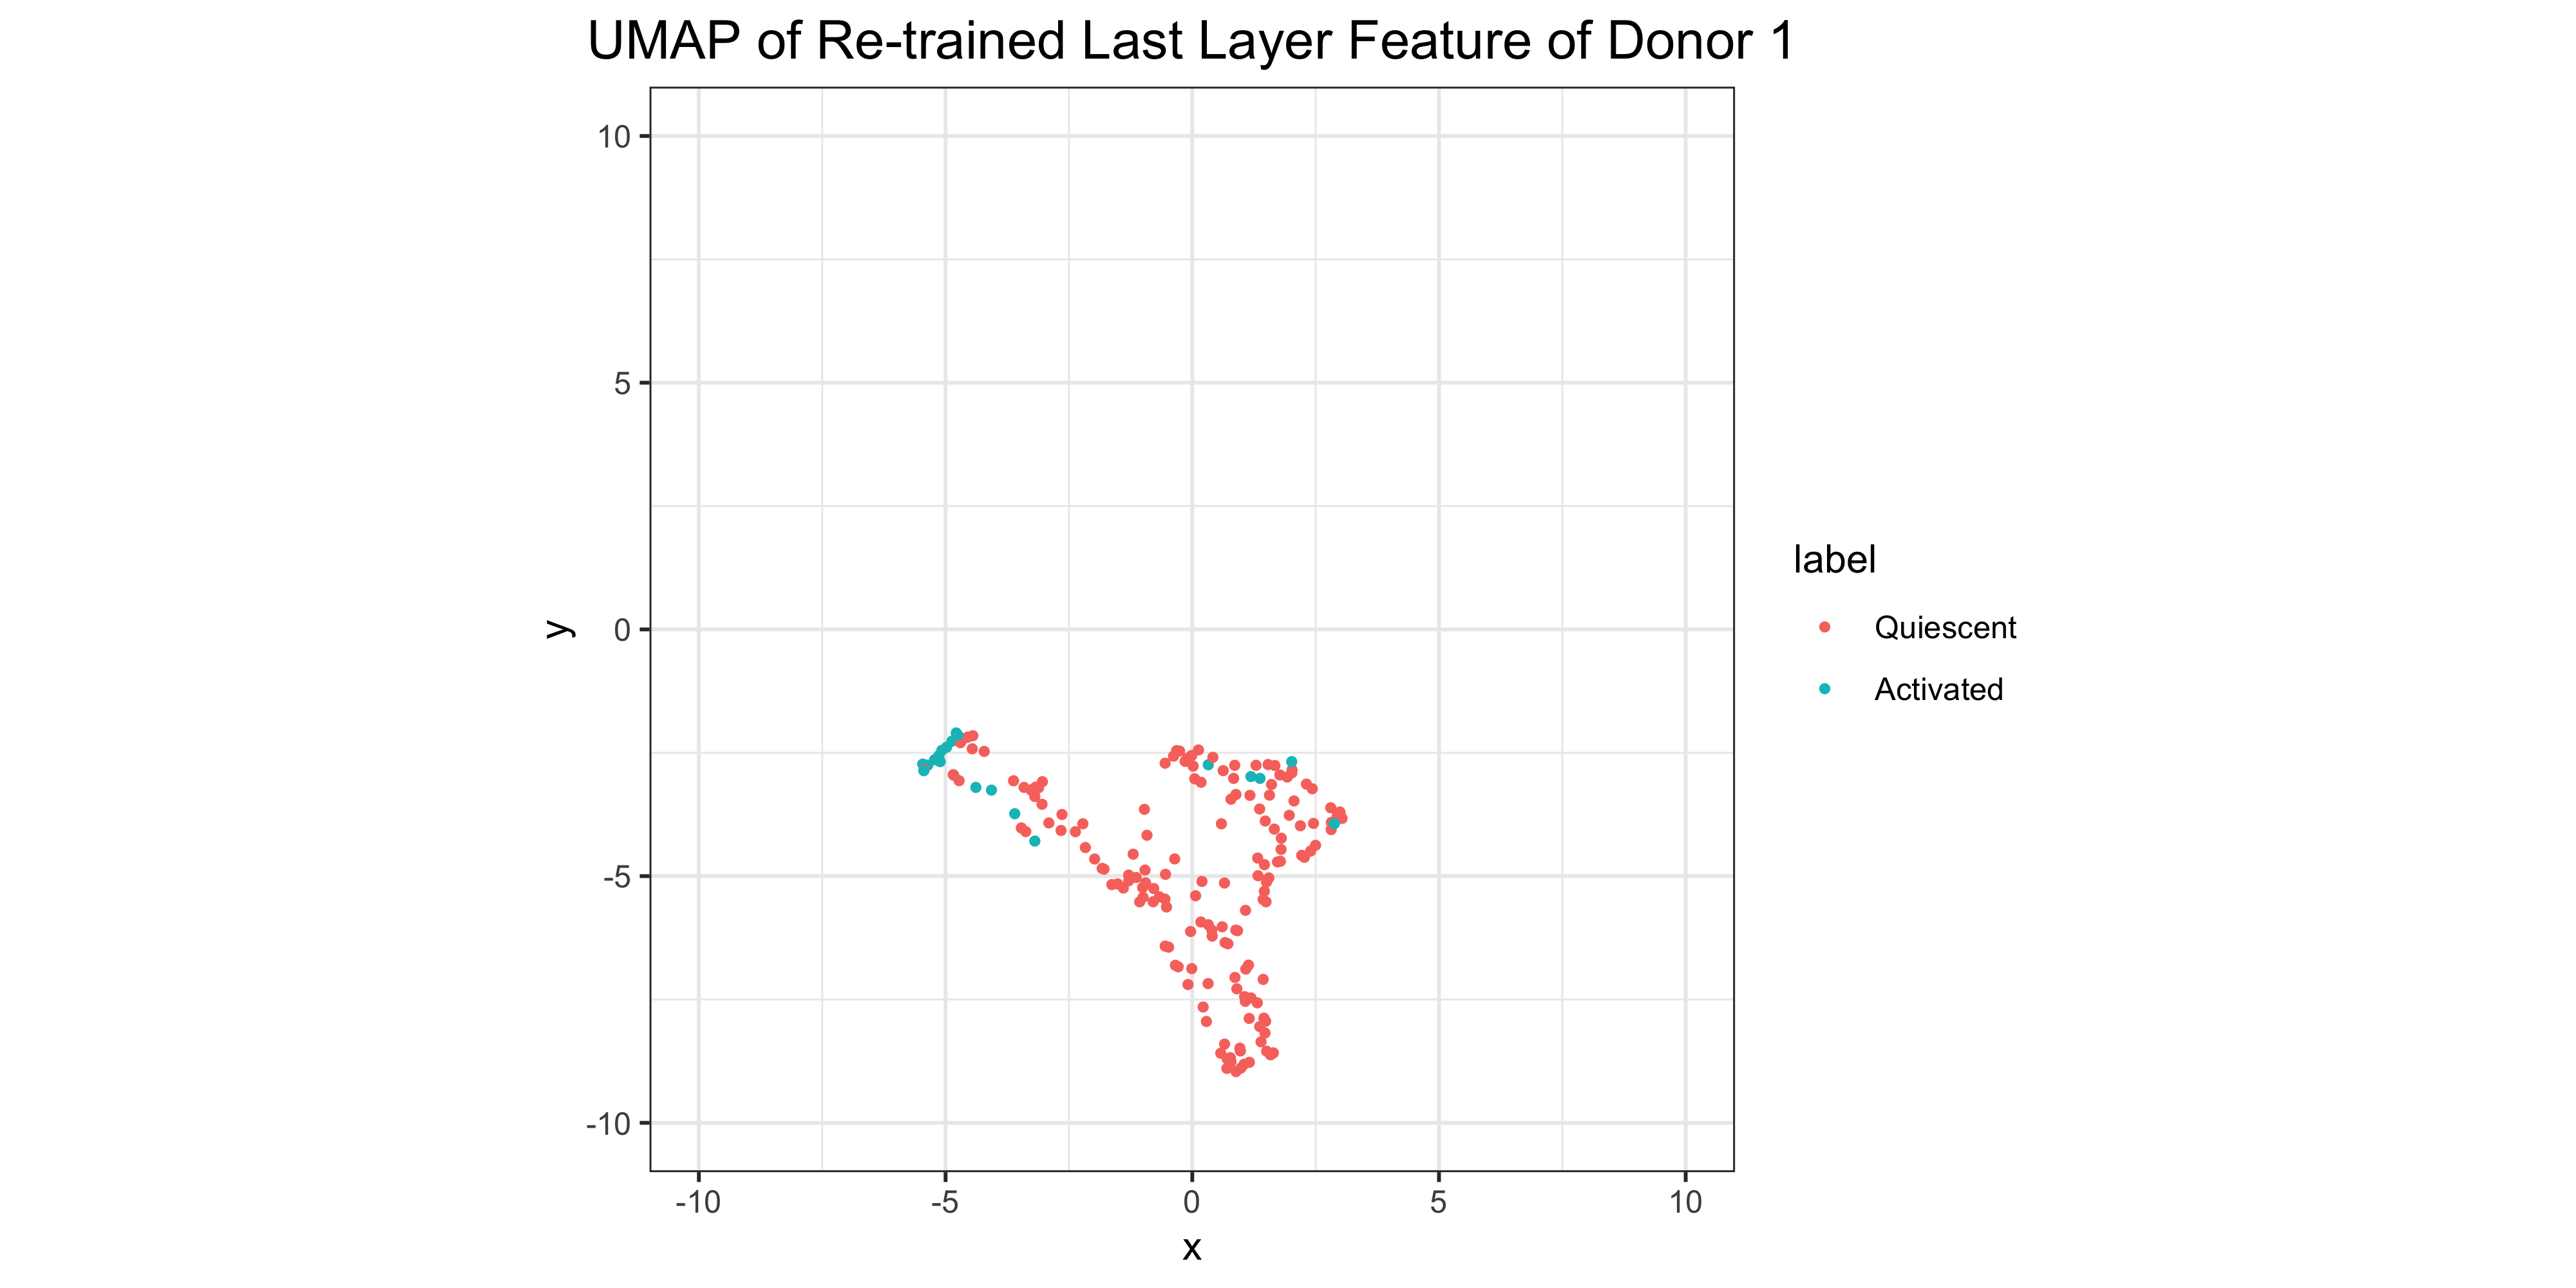

In [55]:
%%R -i umap_2d_df -w 10 -h 5 --units in -r 400

library("ggplot2")

umap_2d_df$label = factor(umap_2d_df$label, levels=c(0, 1),
                          labels=c("Quiescent", "Activated"))

p1 = ggplot(umap_2d_df, aes(x=x, y=y, color=label)) +
    geom_point(size=0.8) +
    xlim(c(-10, 10)) +
    ylim(c(-10, 10)) +
    coord_fixed() +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5, size=15)) +
    ggtitle("UMAP of Re-trained Last Layer Feature of Donor 1")
p1

Feature cluster visualization can help us diagnose machine learning models. From this 2D UMAP scatter plot above, we can see that there is a small cluster of activated instances that is away from quiescent instances. This small cluster of activated images is not perfectly separated from the quiescent dots, which correlates to the low average precision (69.24%) for this model.

Training on the full dataset (10 times more training data) will form two clearly separated clusters, where each corresponds to a cell activity label.

### 4.2. Temperature Scaling

For classification problems, people are usually interested in model's prediction confidence. We have softmax activation on the output layer. Softmax scores fall in the range of $\left(0, 1\right)$ which could be treated as the output probability, but studies have shown this calibration is overconfident.

One easy alternative is to apply temperature scaling. The idea of this method is to use a variable $T$ to scale the logit, the input value of the softmax function, before computing its softmax score. The variable $T$ is chosen to  optimize the negative log likelihood (NLL) on the validation set, where NLL can indirectly measure model's calibration quality.

In the outer loop of our nested-cross validation, we have recorded the validation set for early stopping. In this section, we will use images in this validation set to choose $T$ and then compute a scaled softmax score as the classification confidence.

In [56]:
# We define the following three variables instead of using constants here,
# so you can modify the code to a function if that fits your workflow.
donor = 1
pre_layer = 'mixed9'

# Load the lower layers
bottom_model = create_transfer_learning_model(pre_layer)
bottom_model.load_weights('./resource/saved_weights_fine_tuning_donor_1.h5')

before_last_layer_model = Model(inputs=bottom_model.input,
                                outputs=bottom_model.layers[-2].output)

# Get logits from this network
# One way is to manually do the linear algebra -> weights * layer output + bias
# Another way is to swap the last layer activation function, so predict() gives
# the logits
bottom_model.layers[-1].activation = activations.linear
bottom_model = utils.apply_modifications(bottom_model)

/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [57]:
# Load validation set information
results = load(open('./resource/transfer_fine_tuning_test_result.json', 'r'))
vali_names = results[str(donor)]['vali_name']


# When we test donor 1, we are training on donors 2, 3, 5, 6, so we need to
# load those bottlenecks
vali_bottlenecks, vali_labels = [], []

bottleneck_dir = './images/sample_images/bottlenecks/bottleneck_mixed9'
vali_bottleneck_files = [join(bottleneck_dir, v) for v in vali_names]

for b in vali_bottleneck_files:
    cur_feature = np.load(b)['features']
    vali_bottlenecks.append(cur_feature)
    vali_labels.append(0 if 'noact' in b else 1)

vali_bottlenecks = np.stack(vali_bottlenecks)
print("Shape of vlidation features: {}".format(vali_bottlenecks.shape))

Shape of vlidation features: (111, 8, 8, 2048)


In [58]:
# Convert the label to one-hot encoding
vali_labels_onehot = np.vstack([[0, 1] if i == 1 else [1, 0] for i in vali_labels])

# Extract the logits using those vali_features (we have converted the softmax
# to linear, so the predict() output is logit)
vali_logits = bottom_model.predict(vali_bottlenecks)
print(vali_logits.shape)

del bottom_model

(111, 2)


In [59]:
vali_logits[:10]

array([[ -1.0368552,   1.3934342],
       [  4.842605 ,  -4.6875396],
       [  7.0914464,  -6.8573556],
       [-10.40509  ,  10.935875 ],
       [ -3.344979 ,   3.6972606],
       [  5.8901944,  -5.743445 ],
       [-10.987155 ,  11.200308 ],
       [ -8.128218 ,   8.213914 ],
       [  6.3008323,  -5.9478455],
       [  6.5974264,  -6.388474 ]], dtype=float32)

In [60]:
# Jupyter-specific issue:
# It is very important to separate our tf code from the keras code. It could
# mess up the underlying graphs in keras' scope.
#
# One way is to use tf.reset_default_graph(), but it has undefined behavior with
# keras graph (especially K.clear_session())
# https://stackoverflow.com/a/50047139/5379444
#
# Here we create a new graph scope for the optimizaiton code. If you are running
# this single cell in a script, then you don't need to create a new tf.Graph().

with tf.Graph().as_default():

    # Then we use TF to find T which minimizes the negative log likelihood
    # Note that temperature > 0
    temperature = tf.Variable(initial_value=tf.random_uniform([1], 0, 10),
                              name='temperature')

    # Combine softmax and lln using softmax_cross_entory according to:
    # https://github.com/gpleiss/temperature_scaling/blob/master/temperature_scaling.py
    loss = tf.losses.softmax_cross_entropy(vali_labels_onehot,
                                           vali_logits / temperature)

    # Use tensorflow to optimize our loss function
    train_step = tf.contrib.opt.ScipyOptimizerInterface(
                    loss,
                    method='L-BFGS-B',
                    options={'maxiter': 100})

    optimal_temperature = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_step.minimize(sess)
        optimal_temperature = sess.run(temperature)[0]

    print("The optimal temperature for donor {} is {}".format(
        donor, optimal_temperature))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.191998
  Number of iterations: 2
  Number of functions evaluations: 4
The optimal temperature for donor 1 is 3.7796735763549805


After getting $T$, we can write a function to compute the temperature scaled softmax score.

In [61]:
def get_confidence(bottlenecks, pre_layer, weight_file, temperature):
    """
    Compute the temperature scaled classification confidence score for the
    given image using given model with weights.

    Args:
        bottlenecks(np.array(bottleneck)): batch of bottlenecks: each bottleneck
            is the extracted feature for one image
        pre_layer(str): the layer before the fine-tuning layers
        weight_file(str): paht to the h5 file with fine-tuned weights
        temperature(float): the temperature score used to scale the logits before
            computing the softmax. It should be selected to optimize NLL on the
            validation set.
            
    Returns:
        confidences(np.array([conf_0, conf_1])): batches of confidence scores:
            conf_0 is the confidence of positive classification. conf_0 and
            conf_1 sum to 1.
            
    """
    
    # Create a network to extract logits for this bottleneck
    bottom_model = create_transfer_learning_model(pre_layer)
    bottom_model.load_weights(weight_file)

    bottom_model.layers[-1].activation = activations.linear
    bottom_model = utils.apply_modifications(bottom_model)
    
    # Get the logits
    logit = bottom_model.predict(bottlenecks)
    
    # Get the scaled softmax            
    confidences = softmax(logit/temperature)
    del bottom_model
    
    return confidences

In [62]:
# Test computing the confidence on the first validation bottleneck
confidences = get_confidence(np.array([vali_bottlenecks[0]]), pre_layer,
                             './resource/saved_weights_fine_tuning_donor_1.h5',
                             optimal_temperature)

print('We are {:.2f}% confident that cell image "{}" is {}.'.format(
    confidences[0][np.argmax(confidences)] * 100,
    basename(vali_bottleneck_files[0]).replace('npz', 'png'),
    # Temperature scaling does not change prediction
    'quiescent' if confidences[0][0] > confidences[0][1] else 'activated'
))

We are 65.54% confident that cell image "CD8_3_act_6_4_9.png" is activated.


### 4.3. Misclassified Image Visualization

Visualizing test set images that are misclassified help us gain more insights regarding the classifier as well as our dataset. If our classifier tends to make mistakes on a certain type of image, we could modify the image processing pipeline to further improve the model performance.

In [63]:
# Get misclassified image list
donor = 1
pre_layer = 'mixed9'

results = load(open('./resource/transfer_fine_tuning_test_result.json', 'r'))
test_names = np.array(results[str(donor)]['y_true_name'])
y_true = np.array(results[str(donor)]['y_true'])
y_score = results[str(donor)]['y_score']
y_pred = np.array([1 if i >= 0.5 else 0 for i in y_score])
error_names = test_names[y_pred != y_true]

# Double check if we count errors correctly
print("Error proportion = {:.4f}, (1 - acc) = {:.4f}.".format(
    len(error_names)/len(y_true), 1 - results[str(donor)]['acc']))

error_names

Error proportion = 0.0919, (1 - acc) = 0.0919.


array(['CD8_1_noact_2_2_82.npz', 'CD3_1_noact_10_2_139.npz',
       'CD8_1_noact_2_2_80.npz', 'CD8_1_noact_2_2_41.npz',
       'CD8_1_act_4_2_14.npz', 'CD8_1_noact_2_3_70.npz',
       'CD8_1_noact_2_1_136.npz', 'CD3_1_act_9_4_38.npz',
       'CD3_1_act_9_4_16.npz', 'CD3_1_act_9_3_18.npz',
       'CD3_1_noact_10_5_4.npz', 'CD8_1_act_4_2_11.npz',
       'CD8_1_noact_2_3_59.npz', 'CD8_1_act_4_5_4.npz',
       'CD8_1_act_4_4_1.npz', 'CD8_1_noact_2_1_147.npz',
       'CD8_1_noact_2_3_5.npz'], dtype='<U24')

In [64]:
# Collect bottlenecks from these misclassified images
error_bottlenecks = []

bottleneck_dir = './images/sample_images/bottlenecks/bottleneck_mixed9'
error_bottleneck_files = [join(bottleneck_dir, v) for v in error_names]

for b in error_bottleneck_files:
    cur_feature = np.load(b)['features']
    error_bottlenecks.append(cur_feature)

error_bottlenecks = np.stack(error_bottlenecks)
print("Shape of error bottlenecks: {}".format(error_bottlenecks.shape))

error_confidences = get_confidence(error_bottlenecks, pre_layer,
                                   './resource/saved_weights_fine_tuning_donor_1.h5',
                                   3.7)

error_confidences

Shape of error bottlenecks: (17, 8, 8, 2048)


array([[1.0705075e-01, 8.9294922e-01],
       [1.1844819e-01, 8.8155180e-01],
       [1.8963228e-01, 8.1036770e-01],
       [2.2202477e-01, 7.7797520e-01],
       [9.8053968e-01, 1.9460388e-02],
       [2.8019553e-01, 7.1980447e-01],
       [4.3698090e-01, 5.6301904e-01],
       [6.6877359e-01, 3.3122638e-01],
       [9.3471146e-01, 6.5288574e-02],
       [6.7733121e-01, 3.2266879e-01],
       [3.9422885e-01, 6.0577118e-01],
       [9.9015397e-01, 9.8460950e-03],
       [2.9441136e-01, 7.0558864e-01],
       [9.9994648e-01, 5.3468630e-05],
       [9.6810615e-01, 3.1893782e-02],
       [3.4711562e-02, 9.6528840e-01],
       [4.2784870e-02, 9.5721507e-01]], dtype=float32)

In [65]:
def quick_write(img, text, location):
    """
    A wrapper function to add text on image using openCV. This function does not
    return anything. It writes on the img directly.
    
    Args:
        img(np.array): image pixel matrix
        text(str): the text to write on
        location((int, int)): the text location
    """
    
    cv2.putText(img, text, location, cv2.FONT_HERSHEY_SIMPLEX, 1,
                (255, 255, 255), 2, cv2.LINE_AA)

In [66]:
def montage_images(img_list, n_col, image_size=50, margin=2):
    """
    Plot all the images listed in `img_names` in a gird with `n_col` columns.
    Images will be resized to `image_size`*`image_size`.
    This function assumes input images have the same shape.
    
    Args:
        img_list([np.array]): list of image pixel matrices
        n_col(int): number of images in one row
        image_size(int): the length of each image on the montage view
        margin(int): the horizonal and vertical gap between image image
        
    Returns:
        np.array: The montage view of all images listed in `img_names`
    """

    temp_img_list = [cv2.resize(i, (image_size, image_size)) for i in img_list]
    stack = np.hstack(temp_img_list)

    # Compute number of rows
    n_row = math.ceil(len(img_list) / n_col)
    image = np.ones((n_row * image_size + (n_row - 1) * margin,
                     n_col * image_size + (n_col - 1) * margin)) * 255

    for i in range(int(stack.shape[1] / image_size)):
        r, c = i // n_col, i % n_col
        image[image_size * r + r * margin : image_size * (r + 1) + r * margin,
              image_size * c + c * margin : image_size * (c + 1) + c * margin
             ] = stack[:, image_size * i : image_size * (i + 1)]
        
    return image

In [67]:
edited_image_list = []

# Write predictive score on the error image
for i in range(len(error_names)):
    name = error_names[i].replace('npz', 'png')
    confidence = error_confidences[i]

    # Find the image path
    if "noact" in name:
        cur_dir = './images/sample_images/processed/augmented/donor_{}/quiescent'.\
            format(donor)
        predict = "Activated"
    else:
        cur_dir = './images/sample_images/processed/augmented/donor_{}/activated'.\
            format(donor)
        predict = "Quiescent"
        
    # Load the image
    img_gray = cv2.imread(join(cur_dir, name), 0)
    img = cv2.resize(img_gray, (512, 512))
    
    # Add text label
    quick_write(img, 'Wrong Prediction: {}'.format(predict), (42, 450))
    quick_write(img, 'Confidence: {0:.2f}, {1:.2f}'.format(*confidence),
                (135, 490))
    
    edited_image_list.append(img)

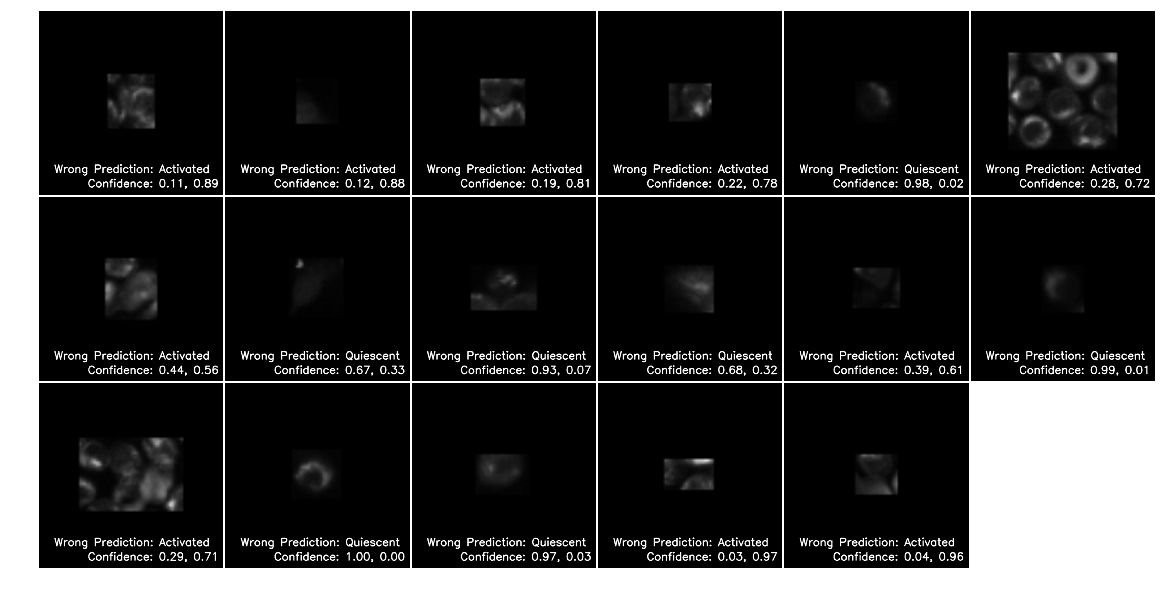

In [68]:
# Montage all images
montage = montage_images(edited_image_list, 6, image_size=1024, margin=10)

plt.figure(figsize=(20, round(montage.shape[1] / montage.shape[0] * 20)))
plt.imshow(montage, cmap='gray')
plt.axis('off')
plt.show()

One interesting pattern above is that our model tends to predict images with multiple cells as activated when the image is actually labeled as quiescent.

### 4.4. Saliency Map

Saliency map is a technique to visualize the regions in the image where a small change can greatly influence the classification result. It helps us learn where the network pays attention on the image. It is useful to diagnose our model and sometimes gain insights about the images.

In this section, we will use Python package `keras-vis` to plot the saliency map of the fine-tuning model for some donor 1 images. Since we are changing the model structure (only working on lower levels), it is tricky to use `keras-vis` directly. Therefore, we first create a full Inception v3 with ImageNet weights as the base model, and then we copy the trained weights onto the fine-tuned lowers layers of the base model. Then, this model supports raw image pixel as input, instead of bottlenecks.

In [69]:
def get_combined_model(pre_layer, weights_file):
    """
    Load retrained weights on lower layers of a complete Inception V3 model with
    imagenet weights.
    
    Args:
        pre_layer(str): the layer before fine tuning layers
        weight_file(str): path to the h5 file with re-trained weights
        
    Returns:
        combined_model: a complete Inception V3 keras model with imagenet
            weights where lower layers (specified by `num_layer`) have retrained
            weights loaded from weights_file
    """
    
    # Get the retrained model and its weights
    bottom_model = create_transfer_learning_model(pre_layer)
    bottom_model.load_weights(weights_file)

    # Get the imagenet base model
    base_model = InceptionV3(weights='imagenet', include_top=False,
                             input_shape=(299, 299, 3))
    
    # Fill the combined model (no retrained weights yet)
    x = base_model.output
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    predictions = Dense(2, activation="softmax", name="prediction")(x)
    combined_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Update weights in combined model
    layer_len = len(bottom_model.layers)
    print("Num of layers: {}".format(layer_len))

    retrained_layers = combined_model.layers[-layer_len:]

    # Update lower level weights in the base model
    # We start from 1 to skip the input layer of our customed model
    for i in range(1, len(retrained_layers)):
        weight_list_1 = retrained_layers[i].get_weights()
        weight_list_2 = bottom_model.layers[i].get_weights()
        assert(len(weight_list_1) == len(weight_list_2))
        
        if len(weight_list_1) > 0:
            assert(weight_list_1[0].shape == weight_list_2[0].shape)

        retrained_layers[i].set_weights(
            bottom_model.layers[i].get_weights()
        )

    combined_model.layers[-layer_len:] = retrained_layers

    del bottom_model
    
    return combined_model

In [70]:
pre_layer = 'mixed9'

combined_model = get_combined_model(
    pre_layer,
    './resource/saved_weights_fine_tuning_donor_1.h5'
)

Num of layers: 34


In [71]:
# Swap the output softmax with linear
layer_idx = utils.find_layer_idx(combined_model, 'prediction')
combined_model.layers[layer_idx].activation = activations.linear
combined_model = utils.apply_modifications(combined_model)

In [72]:
# Visualize the saliency map for a few donor 1 images
image_list = ['./images/sample_images/processed/augmented/donor_1/activated/' +
              'CD3_1_act_9_6_33.png',
              './images/sample_images/processed/augmented/donor_1/quiescent/' +
              'CD3_1_noact_10_1_57.png']

original, gradients, gradients_guided = [], [], []

for image in image_list:
    img_gray = cv2.imread(image, 0)
    original.append(img_gray)
    
    # Resize it to fit the base model input size
    img = np.array([resize(img_gray, (299, 299, 3))])
    index = 0 if "noact" in image else 1
    
    # Generate two kinds of saliency maps
    grad = visualize_saliency(combined_model, layer_idx, filter_indices=index,
                               seed_input=img, backprop_modifier=None)
    grad_guided = visualize_saliency(combined_model, layer_idx,
                                      filter_indices=index, seed_input=img,
                                      backprop_modifier="guided")
    
    gradients.append(grad)
    gradients_guided.append(grad_guided)

/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


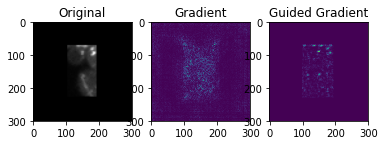

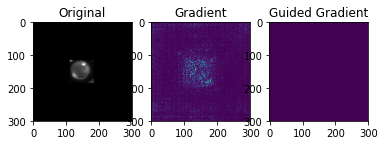

In [73]:
for i in range(len(image_list)):
    f, ax = plt.subplots(1, 3)
    cur_ori = resize(original[i], (299, 299)) * 255
    
    ax[0].set_title('Original')
    ax[0].imshow(cur_ori, cmap='gray') 
    
    ax[1].set_title('Gradient')
    ax[1].imshow(gradients[i], cmap='viridis')
    
    ax[2].set_title('Guided Gradient')
    ax[2].imshow(gradients_guided[i], cmap='viridis')

We used two methods to generate saliency maps: backpropagation and guided backpropagation. The guided method failed to generate saliency map for the second image (quiescent).

From these saliency maps we can see the fine-tuned model pays attention to the real cell region instead of the black padding. The guided saliency map picks up high intensity regions in the activated cell. According to this [paper](https://arxiv.org/abs/1810.03292), the guided saliency map is not sensitive to the random data/model modification. Therefore, even though it is a very popular method to generate nice saliency map, the interpretation of such method is limited.

In [74]:
# Clean memory use of section 4
del (extract_model, interested_inputs, interested_names, interested_labels,
     extracted_features)

del (before_last_layer_model, results, vali_bottlenecks, vali_labels,
     bottlenecks, vali_labels_onehot, vali_logits)

del (test_names, y_true, y_score, y_pred, error_names, error_bottlenecks,
     error_confidences, img_gray, edited_image_list,
     montage, combined_model, original, gradients, gradients_guided)

## 5. Model Comparison

In this section, we use visualization to compare the test results on five test donors of all classifiers: [frequency classifier](./frequency_classifier.ipynb), [logistic regressions](./logistic_regression.ipynb), [simple neural network](./simple_neural_network.ipynb), [simple CNN](./simple_cnn_lenet.ipynb), and transfer learning (off-the-shelf and fine-tuning).

In [75]:
# Build a big dataframe containing all the test results
summary_dict = {
    'method': [],
    'donor': [],
    'auc': [],
    'ap': [],
    'acc': []
}

# Frequency classifier
fq_model_performance = np.load('./resource/frequency_model_performance.npz')
fq_model_performance = fq_model_performance['model_performance'].item()
cur_method = 'Frequency Classifier'

for d in [1, 2, 3, 5, 6]:
    summary_dict['method'].append(cur_method)
    summary_dict['donor'].append(d)
    summary_dict['auc'].append(fq_model_performance[d]['aroc'])
    summary_dict['ap'].append(fq_model_performance[d]['ap'])
    summary_dict['acc'].append(fq_model_performance[d]['acc'])

# Three logistic regressions
npz_data = np.load('./resource/lr_model_performance.npz')
performance_collection_dict = npz_data['performance_collection_dict'].item()

for m in performance_collection_dict:
    for d in [1, 2, 3, 5, 6]:
        cur_model = performance_collection_dict[m]
        summary_dict['method'].append(m)
        summary_dict['donor'].append(d)
        summary_dict['auc'].append(cur_model[d]['aroc'])
        summary_dict['ap'].append(cur_model[d]['ap'])
        summary_dict['acc'].append(cur_model[d]['acc'])

# Simple neural network
results = load(open('./resource/nn_test_result.json', 'r'))
cur_method = 'Simple Neural Network'

for d in [1, 2, 3, 5, 6]:
    summary_dict['method'].append(cur_method)
    summary_dict['donor'].append(d)
    summary_dict['auc'].append(results[str(d)]['aroc'])
    summary_dict['ap'].append(results[str(d)]['ap'])
    summary_dict['acc'].append(results[str(d)]['acc'])

# Simple CNN
results = load(open('./resource/lenet_test_result.json', 'r'))
cur_method = 'Simple CNN'

for d in [1, 2, 3, 5, 6]:
    summary_dict['method'].append(cur_method)
    summary_dict['donor'].append(d)
    summary_dict['auc'].append(results[str(d)]['aroc'])
    summary_dict['ap'].append(results[str(d)]['ap'])
    summary_dict['acc'].append(results[str(d)]['acc'])

# Transfer learning
# Pre-trained CNN off-the-shelf model
results = load(open('./resource/transfer_off_the_shelf_test_result.json', 'r'))
cur_method = 'Transfer Learning (off-the-shelf)'

for d in [1, 2, 3, 5, 6]:
    summary_dict['method'].append(cur_method)
    summary_dict['donor'].append(d)
    summary_dict['auc'].append(results[str(d)]['auc'])
    summary_dict['ap'].append(results[str(d)]['ap'])
    summary_dict['acc'].append(results[str(d)]['acc'])
    
# Pre-trained CNN fine-tuning model
results = load(open('./resource/transfer_fine_tuning_test_result.json', 'r'))
cur_method = 'Transfer Learning (fine-tuning)'

for d in [1, 2, 3, 5, 6]:
    summary_dict['method'].append(cur_method)
    summary_dict['donor'].append(d)
    summary_dict['auc'].append(results[str(d)]['auc'])
    summary_dict['ap'].append(results[str(d)]['ap'])
    summary_dict['acc'].append(results[str(d)]['acc'])
    
metric_df = pd.DataFrame(summary_dict)
metric_df

,method,donor,auc,ap,acc
0,Frequency Classifier,1,0.500000,0.118919,0.881081
1,Frequency Classifier,2,0.500000,0.812500,0.187500
2,Frequency Classifier,3,0.500000,0.265896,0.734104
3,Frequency Classifier,5,0.500000,0.728261,0.271739
4,Frequency Classifier,6,0.500000,0.431373,0.568627
5,LR (Intensities),1,0.737033,0.461245,0.659459
6,LR (Intensities),2,0.712821,0.924718,0.600000
7,LR (Intensities),3,0.871448,0.786678,0.710983
8,LR (Intensities),5,0.746866,0.906287,0.673913
9,LR (Intensities),6,0.896944,0.893820,0.813725


In [76]:
# Count the labels for each donor
count_dict = {}

for d in [1, 2, 3, 5, 6]:
    # Do not count augmented images
    act_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/activated/*.png".format(d))) // 6
    qui_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/quiescent/*.png".format(d))) // 6
    count_dict[d] = {
        'activated': act_count,
        'quiescent': qui_count
    }

count_r_dict = {'count': [], 'donor': [], 'variable': []}
for v in ['Activated', 'Quiescent']:
    for d in [1, 2, 3, 5, 6]:
        count_r_dict['count'].append(
            count_dict[d]['activated'if v == 'Activated' else 'quiescent']
        )
        count_r_dict['donor'].append(d)
        count_r_dict['variable'].append(v)
count_df = pd.DataFrame(count_r_dict)
count_df

,count,donor,variable
0,22,1,Activated
1,65,2,Activated
2,46,3,Activated
3,67,5,Activated
4,44,6,Activated
5,163,1,Quiescent
6,15,2,Quiescent
7,127,3,Quiescent
8,25,5,Quiescent
9,58,6,Quiescent


In [77]:
%reload_ext rpy2.ipython

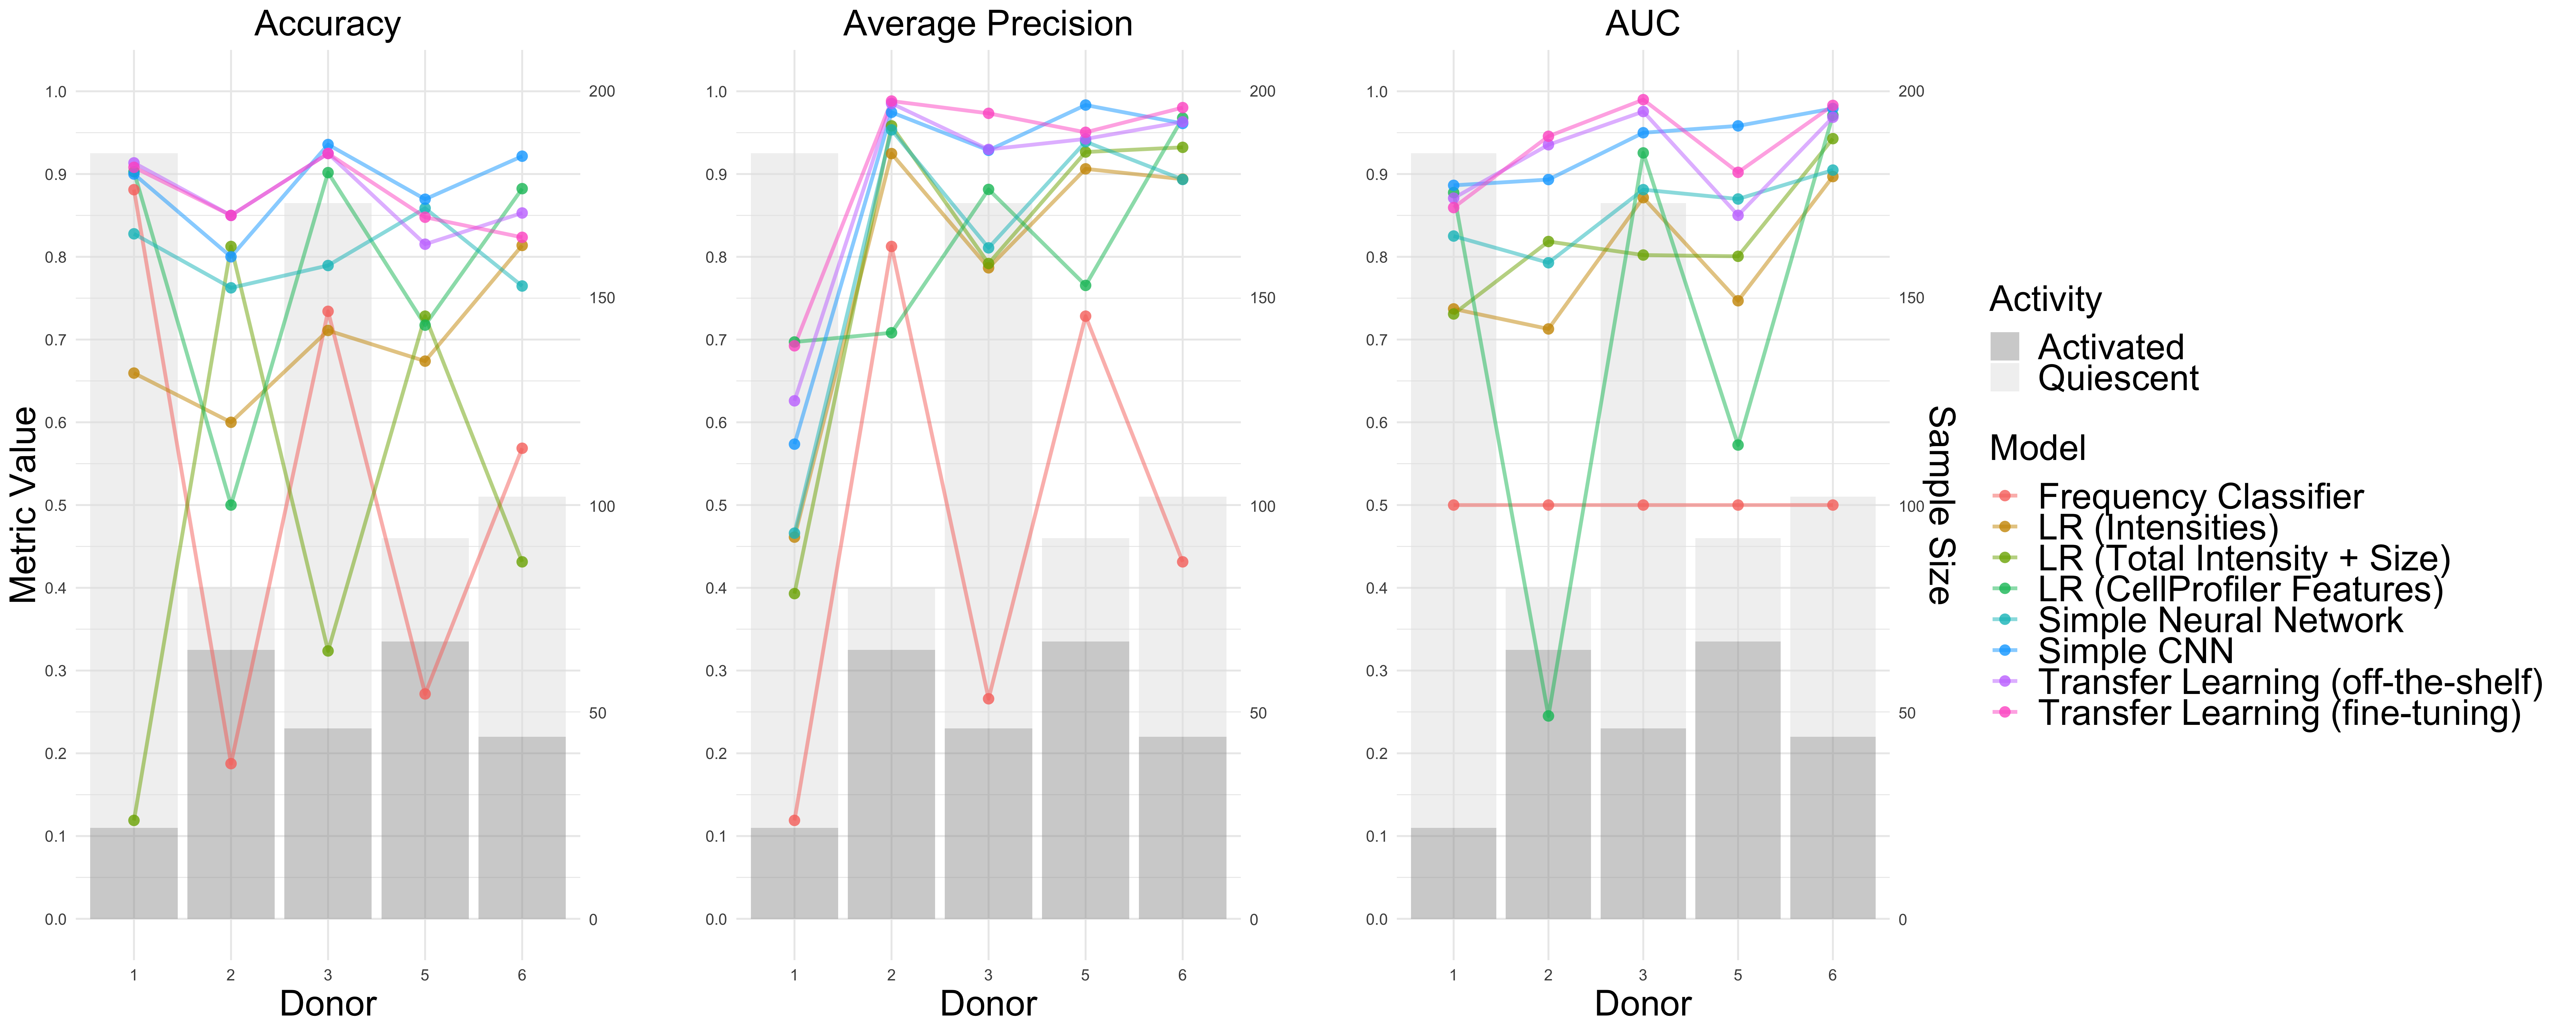

In [78]:
%%R -i metric_df,count_df -w 20 -h 8 --units in -r 400

library("magrittr")
library("ggplot2")
library("ggpubr")

level_order = c("Frequency Classifier",
                "LR (Intensities)",
                "LR (Total Intensity + Size)",
                "LR (CellProfiler Features)",
                "Simple Neural Network",
                "Simple CNN",
                "Transfer Learning (off-the-shelf)",
                "Transfer Learning (fine-tuning)")

# Convert discrete columns into R factors
metric_df$donor = factor(metric_df$donor)
metric_df$method = factor(metric_df$method, levels=level_order)
count_df$variable = factor(count_df$variable)
count_df$donor = factor(count_df$donor)

line_size = 1
point_size = 3

# Accuracy plot
p1 = ggplot() +
    scale_y_continuous(sec.axis = sec_axis(~ 200*., name=""),
                       breaks = scales::pretty_breaks(n = 10),
                       limits = c(0, 1)) +
    geom_col(data=count_df, aes(x=donor, y=count/200, fill=variable),
             position = position_stack(reverse = TRUE)) +
    geom_line(data=metric_df, aes(x=donor, y=acc, color=method, group=method),
              size=line_size, alpha=0.5) +
    geom_point(data=metric_df, aes(x=donor, y=acc, color=method),
               size=point_size, alpha=0.8, stroke=0) +
    scale_fill_manual(values=c(alpha("#A2A2A2", 0.5), alpha("#E3E3E3", 0.5))) +
    ggtitle("Accuracy") +
    labs(color="Model", fill="Activity", x="Donor",
         y="Metric Value") +
    theme_minimal()+
    theme(plot.title = element_text(hjust = 0.5, size=20),
          axis.title = element_text(size = 20),
          legend.position = 'none') 

# AP plot
p2 = ggplot() +
    scale_y_continuous(sec.axis = sec_axis(~ 200*., name=""),
                       breaks = scales::pretty_breaks(n = 10),
                       limits = c(0, 1)) +
    geom_col(data=count_df, aes(x=donor, y=count/200, fill=variable),
             position = position_stack(reverse = TRUE)) +
    geom_line(data=metric_df, aes(x=donor, y=ap, color=method, group=method),
              size=line_size, alpha=0.5) +
    geom_point(data=metric_df, aes(x=donor, y=ap, color=method),
               size=point_size, alpha=0.8, stroke=0) +
    scale_fill_manual(values=c(alpha("#A2A2A2", 0.5), alpha("#E3E3E3", 0.5))) +
    ggtitle("Average Precision") +
    labs(color="Model", fill="Activity", x="Donor",
         y="") +
    theme_minimal()+
    theme(plot.title = element_text(hjust = 0.5, size=20),
          axis.title = element_text(size = 20),
          legend.position = 'none') 

# AUC plot
p3 = ggplot() +
    scale_y_continuous(sec.axis = sec_axis(~ 200*., name="Sample Size"),
                       breaks = scales::pretty_breaks(n = 10),
                       limits = c(0, 1)) +
    geom_col(data=count_df, aes(x=donor, y=count/200, fill=variable),
             position = position_stack(reverse = TRUE)) +
    geom_line(data=metric_df, aes(x=donor, y=auc, color=method, group=method),
              size=line_size, alpha=0.5) +
    geom_point(data=metric_df, aes(x=donor, y=auc, color=method),
               size=point_size, alpha=0.8, stroke=0) +
    scale_fill_manual(values=c(alpha("#A2A2A2", 0.5), alpha("#E3E3E3", 0.5))) +
    ggtitle("AUC") +
    labs(color="Model", fill="Activity", x="Donor",
         y="") +
    theme_minimal()+
    theme(plot.title = element_text(hjust = 0.5, size=20),
          axis.title = element_text(size = 20),
          legend.title = element_text(size = 20), 
          legend.text = element_text(size = 20))

# There is a bug of calling ggarrange with common legend in R magic, we
# only plot legend for AUC and manually set up widths here
# ggarrange(p1, p2, p3, ncol=3, legend='right', common.legend=TRUE)
ggarrange(p1, p2, p3, ncol=3, widths=c(1,1,1.9))

This visualization gives a nice view of three metrics of eight classifiers on five donors. It also includes the cell type counts which help us infer the relationship between performance and data skewness.

Even though we are only working on a small subset of images, we can see the performance improves when we are using more complex models, and the transfer learning models dominate across most metrics and test donors.

In [79]:
# Clean memory use of section 5

del summary_dict

## 6. Final Evaluation on Held-out Donor 4

After finalizing our [data processing procedures](./image_processing.ipynb) along with the pipelines for training different classifiers ([frequency classifier](./frequency_classifier.ipynb), [logistic regressions](./logistic_regression.ipynb), [simple neural network](./simple_neural_network.ipynb), [simple CNN](./simple_cnn_lenet.ipynb), and transfer learning), we can finally use our best practice, the pre-trained CNN with fine-tuning model, to test the held-out images from donor 4.

In this set up, we will use the same nested-cross validation scheme to select the fine-tuning model's hyper-parameters (inner loop), and then evaluate the fine-tuned model on donor 4.

### 6.1. Extract Bottlenecks

First, we want to extract bottlenecks for donor 4 as what we did for other donors in [1.1. Extract Bottlenecks](#1.1.-Extract-Bottlenecks).

In [80]:
# make_bottleneck_main('mixed9', donors=[4])
# make_bottleneck_main('mixed8', donors=[4])

### 6.2. Model Tuning

Then, we apply the same nested-cross validation code here to find the optimal hyper-parameters for donor 4. One should note that since we are now using 6 donors in total, for each hyper-parameter combination, there are 5 iterations (runs) in the inner loop, which used to be 4. Similarly, there will be more training data in the outer loop when we evaluate the final performance.

Below is the code to tune donor 4's model with the same hyper-parameter space as in [2.3. Nested Cross-validation](#2.3.-Nested-Cross-validation). It is very slow to run in this notebook, so we have split it into $2 \times 2 \times 2 \times 1 \times 5 = 40$ jobs and run them externally with `epoch=500`. The tuning results are provided at `./resource/transfer_fine_tuning_tune_result_d4.csv`.

In [81]:
layer_candidates = ['mixed8', 'mixed9']
lr_candidates = [0.001, 0.01]
bs_candidates = [16, 32]

# Grid search the best parameter
donors = [1, 2, 3, 4, 5, 6]
for layer in layer_candidates:
    for lr in lr_candidates:
        for bs in bs_candidates:
            test_did = 4
            for vali_did in [i for i in donors if i != test_did]:
                pass
#                cross_validation_main(layer, lr, bs, epoch=500,
#                                      test_did=test_did, vali_did=vali_did)

In [82]:
tuning_result = pd.read_csv('./resource/transfer_fine_tuning_tune_result_d4.csv')

# It has 2 * 2 * 2 = 8 rows
print(tuning_result.shape)
tuning_result

(8, 7)


,Test Donor,Pre-layer,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
0,4,mixed8,0.001,16,0.893940,0.925535,0.949482
1,4,mixed8,0.001,32,0.902584,0.922117,0.943061
2,4,mixed8,0.010,16,0.849629,0.924280,0.944717
3,4,mixed8,0.010,32,0.843500,0.885278,0.952590
4,4,mixed9,0.001,16,0.892135,0.899881,0.925362
5,4,mixed9,0.001,32,0.875525,0.881567,0.926489
6,4,mixed9,0.010,16,0.908752,0.902069,0.932517
7,4,mixed9,0.010,32,0.898284,0.919808,0.941914


In [83]:
# Iterate through all the rows in the dataframe, and find the row which
# has the largest average of average precision for each test donor
best_row = {}

for i, r in tuning_result.iterrows():
    tid = r['Test Donor']
    ap = r['Average of Average Precison']
    
    if tid not in best_row:
        best_row[tid] = (i, ap)
        continue
    
    if ap > best_row[tid][1]:
        best_row[tid] = (i, ap)

best_para_df = tuning_result.iloc[[best_row[i][0] for i in best_row], :]

# Get the best parameter for each test donor [lr, bs, pre_layer]
best_parameters = {}
for i, r in best_para_df.iterrows():
    best_parameters[r['Test Donor']] = [r['Learning Rate'], r['Batch Size'],
                                        r['Pre-layer']]
    
best_para_df

,Test Donor,Pre-layer,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
0,4,mixed8,0.001,16,0.89394,0.925535,0.949482


In [84]:
best_parameters

{4: [0.001, 16, 'mixed8']}

### 6.3. Model Testing

After tuning the transfer learning model for donor 4, we test it using the nested-cross validation outer loop.

In [85]:
# Remove the checkpoint in ./temp if you have run retrain() in previous cells
if exists('./temp/retrain_config.json'):
    os.remove('./temp/retrain_config.json')

# leave_one_out_main('mixed8', 0.001, 16, 4, epoch=1, donors=[1, 2, 3, 4, 5, 6])

The testing results of `epoch=500` is included at `./resource/transfer_fine_tuning_test_result_d4.json`.

In [86]:
result_file = './resource/transfer_fine_tuning_test_result_d4.json'
result = load(open(result_file, 'r'))[str((4, 1))]

# Compute precision and recall
cur_pred = [1 if i >= 0.5 else 0 for i in result['y_score']]
cur_precision = metrics.precision_score(result['y_true'], cur_pred)
cur_recall = metrics.recall_score(result['y_true'], cur_pred)

# Compute the image size for donor 4
# Do not count augmented images
act_count = len(glob("./images/sample_images/processed/" +
                     "augmented/donor_4/activated/*.png")) // 6
qui_count = len(glob("./images/sample_images/processed/" +
                     "augmented/donor_4/quiescent/*.png")) // 6

df = pd.DataFrame({
    'Test Donor': [4],
    'Accuracy': [result['acc']],
    'Precision': [cur_precision],
    'Recall': [cur_recall],
    'Average Precision': [result['ap']],
    'AUC': [result['auc']],
    'Num of Activated': [act_count],
    'Num of Quiescent': [qui_count]
})

df

,Test Donor,Accuracy,Precision,Recall,Average Precision,AUC,Num of Activated,Num of Quiescent
0,4,0.995261,1.0,0.979592,0.998823,0.999622,49,162


The final performance on test donor 4 is higher than all other test donors. One contributor is that donor 4's model is tuned and trained on more images across more donors.

## 7. Summary

In this notebook, we applied the same nested-cross validation scheme to tune and evaluate two transfer learning classifiers: the pre-trained CNN off-the-shelf model and the pre-trained CNN with fine-tuning. Then, we use UMAP clustering, temperature scaling, and saliency map to interpret and diagnose this model. Finally, after comparing all the models we have discussed in this repository, we tested our best model on the held-out donor 4.